In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']
            
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = 'alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R'

In [3]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']

lesion = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42']


brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal'}


rat_markers = {}
intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

for index, animal in enumerate(animalList):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")


0.017212671290369307 0.00820976467420011 0.6770661676307556


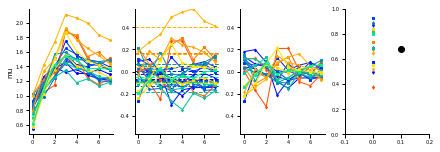

{'RatF00': -0.06769765129053583, 'RatF01': -0.08749952640463406, 'RatF02': -0.018937943439300383, 'RatM00': 0.0072335486862092, 'RatM01': -0.07283586491015855, 'RatM02': 0.037322847000926036, 'RatF30': 0.06763717317427134, 'RatF31': -0.09533590593605536, 'RatF32': -0.12800694579346142, 'RatF33': -0.08934533455000636, 'RatM30': 0.17217598349872745, 'RatM31': 0.037631367749423106, 'RatM32': 0.07111429684248663, 'RatF40': 0.16056946332919925, 'RatF41': 0.4070317171397898, 'RatF42': -0.18891111709927208, 'RatM40': -0.0955226158991658, 'RatM41': -0.10170397484393008, 'RatM42': 0.03743395497210594, 'RatM43': -0.05235347222662124}


In [4]:
def do_stuff(var, name='', animalList=animalList):
    fig, axs = plt.subplots(1, 4, figsize=(6, 2))

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:

        try:
            color = rat_markers[animal][0]
            marker = rat_markers[animal][1]
        except:
            color = 'k'
            marker = 'o'


        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        axs[0].plot(x, y, label=animal, marker='o', markersize=2, color=color)


        #############################""
        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        axs[1].plot(x, y_expected, label=animal, marker=marker, markersize=2, color=color)

        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        axs[1].axhline(y=intercept, linestyle='--', label='Intercept', color=color)
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        axs[2].plot(x, y_corrected, label=animal, marker=marker, markersize=2, color=color)
        remaining_residuals[animal] = np.var(y_corrected)


        temp_ymax = np.max([np.max(np.abs(y_corrected)), np.max(np.abs(y_expected))])

        if temp_ymax > ymax:
            ymax = temp_ymax



    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    ICC_pop = alp / (alp + eps)

    print(alp, eps, ICC_pop)


    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        try:
            color = rat_markers[animal][0]
            marker = rat_markers[animal][1]
        except:
            color = 'k'
            marker = 'o'
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])
        axs[3].scatter(0,  ICC_indiv[animal], color=color, marker=marker, s=5)



    axs[1].set_ylim(-ymax, ymax)
    axs[2].set_ylim(-ymax, ymax)
    
    axs[3].scatter(0.1, ICC_pop, label="ICC_pop", color='black')
    axs[3].set_ylim(0, 1)
    axs[3].set_xlim(-0.1, 0.2)

    axs[0].set_ylabel(name)
    plt.show()
    print(individual_intercepts)

do_stuff(mu, 'mu')
# do_stuff(sigma)
# do_stuff(alpha, 'alpha')

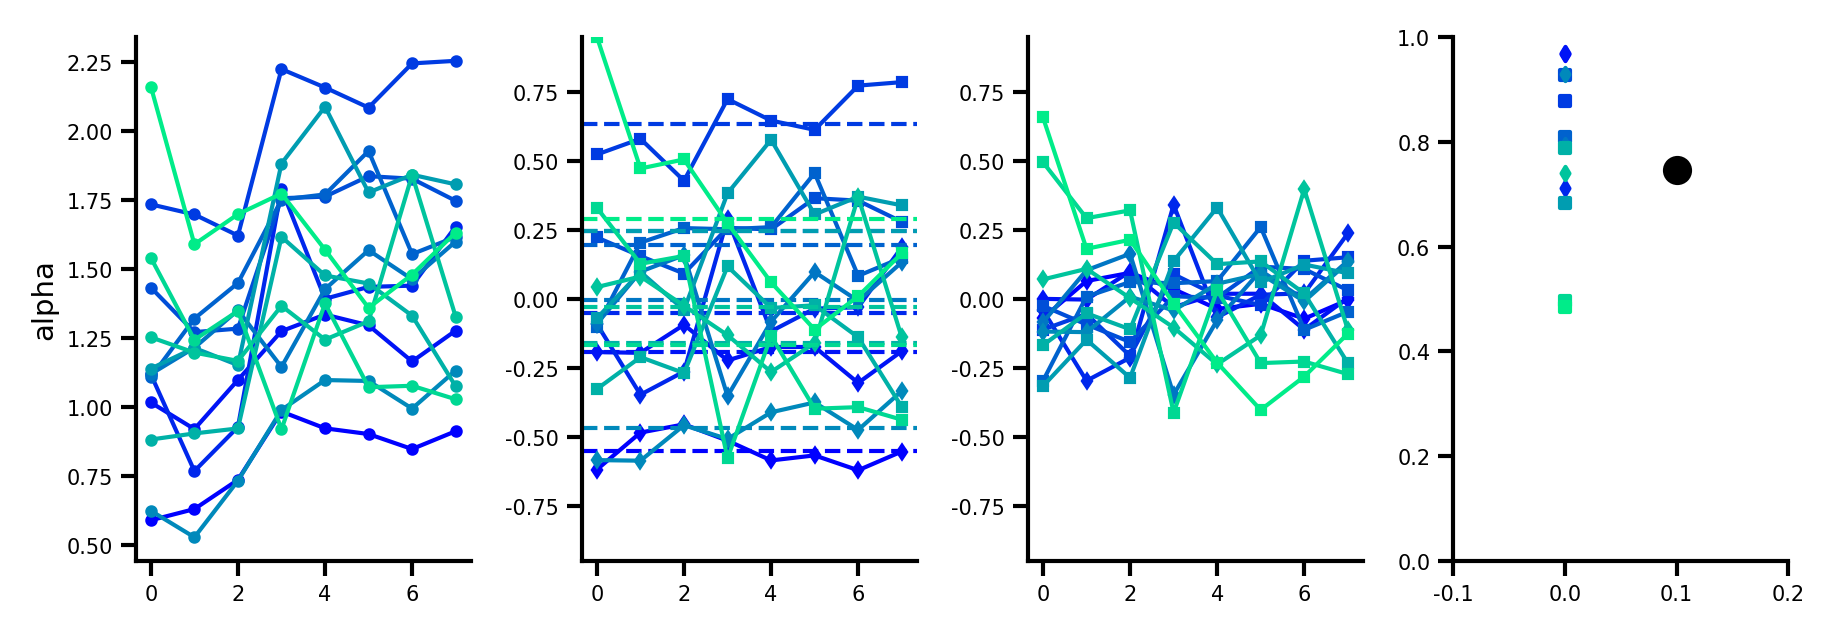

{'RatF00': -0.5500626743880214, 'RatF01': -0.1931936087953162, 'RatF02': -0.05048303657510113, 'RatM00': 0.6356812099084528, 'RatM01': 0.248371798087379, 'RatM02': 0.19583435057665277, 'RatF32': -0.005092262585041301, 'RatF33': -0.4665730504125287, 'RatM31': 0.24629804632170502, 'RatM32': -0.15904751462831365, 'RatF42': -0.027750061108792624, 'RatM40': -0.1655529931153656, 'RatM43': 0.29156979671429023}


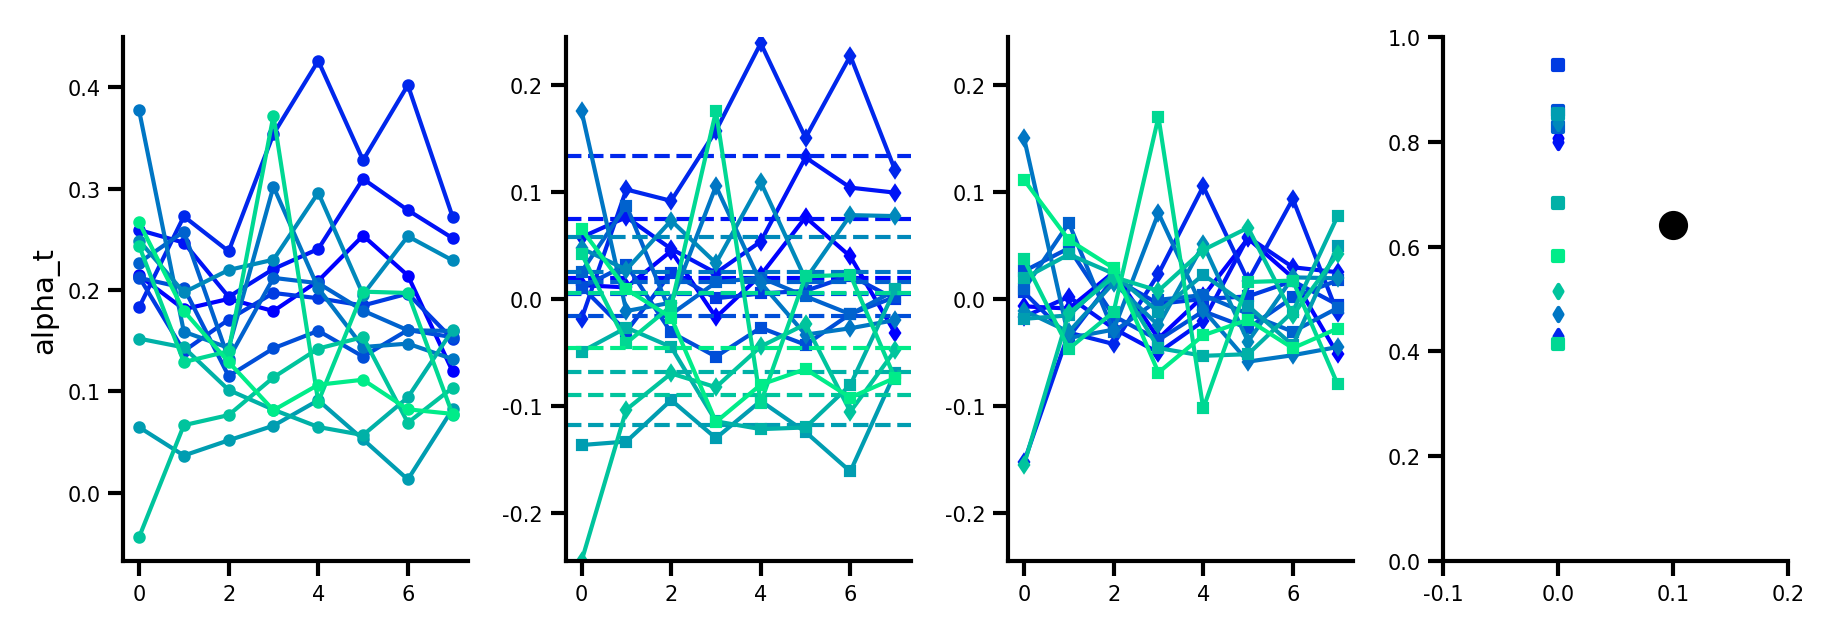

{'RatF00': 0.01984321526195161, 'RatF01': 0.07455947801664871, 'RatF02': 0.1340799657585155, 'RatM00': 0.005161572297657152, 'RatM01': -0.015518956195387157, 'RatM02': 0.016386265022887123, 'RatF32': 0.025241880269273077, 'RatF33': 0.05827959629176168, 'RatM31': -0.1181851690939925, 'RatM32': -0.06862887323269519, 'RatF42': -0.09033768956932257, 'RatM40': 0.005338882775715595, 'RatM43': -0.04622016760301312}


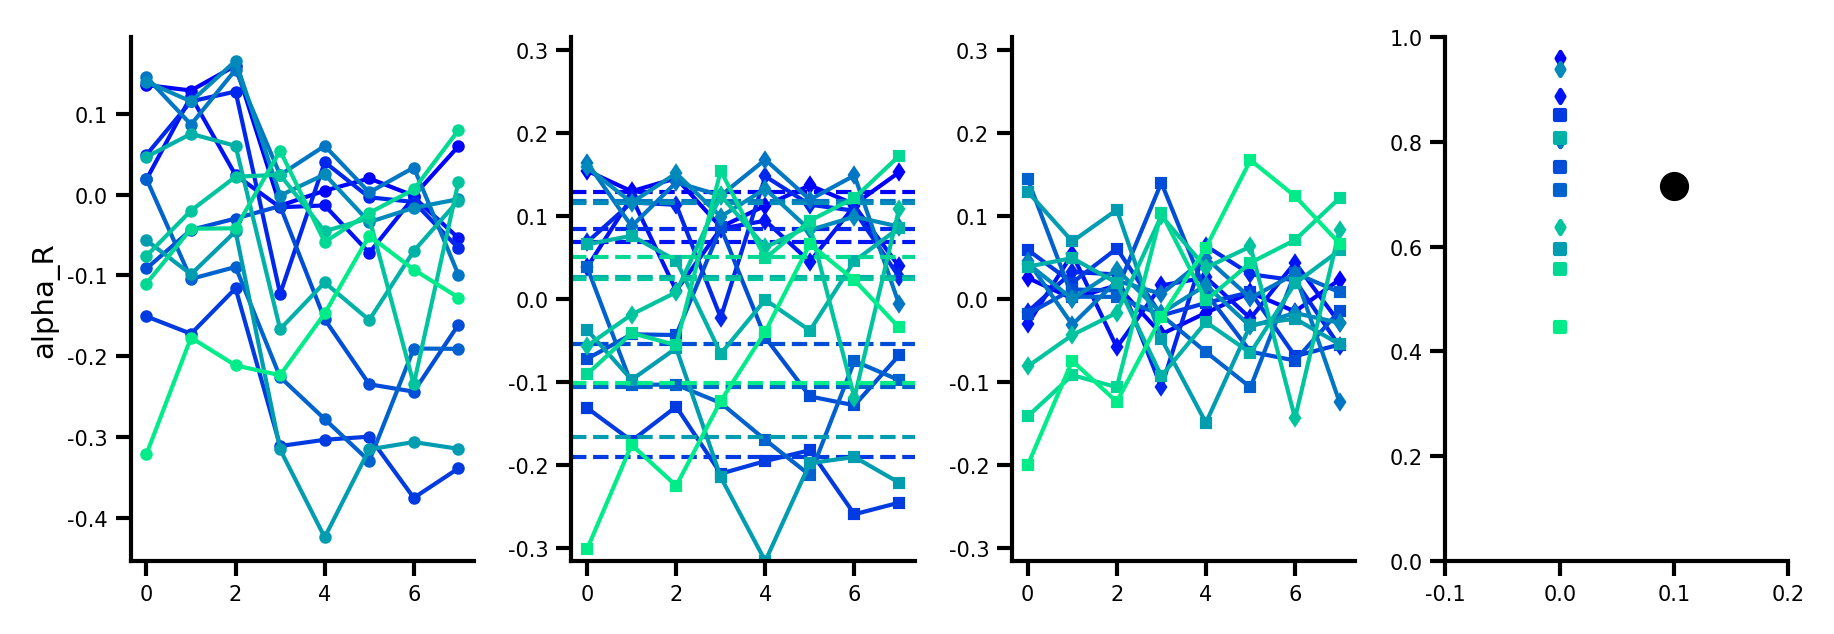

{'RatF00': 0.12915586574216475, 'RatF01': 0.06831465781569816, 'RatF02': 0.0838582613823976, 'RatM00': -0.19053556047571374, 'RatM01': -0.053913920896314055, 'RatM02': -0.10590253725905252, 'RatF32': 0.11854349908733497, 'RatF33': 0.11602163857413543, 'RatM31': -0.16668728814555275, 'RatM32': 0.026898108116223004, 'RatF42': 0.02473977721117853, 'RatM40': 0.0506601522846297, 'RatM43': -0.10115265343712918}


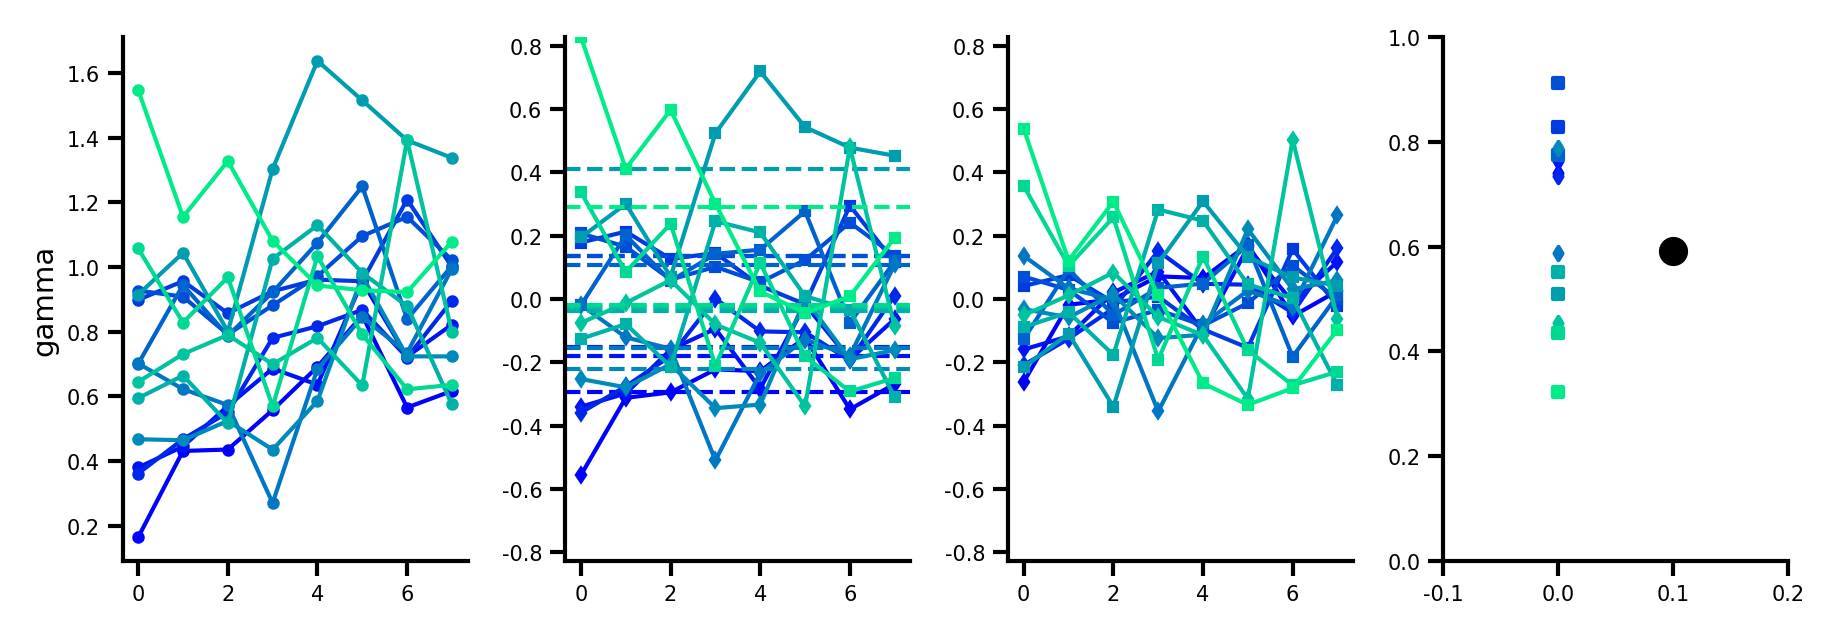

{'RatF00': -0.29385175297407057, 'RatF01': -0.1806741069532366, 'RatF02': -0.15032864350029757, 'RatM00': 0.1374615584663218, 'RatM01': 0.13622702902345332, 'RatM02': 0.10726910079595896, 'RatF32': -0.1545970661744777, 'RatF33': -0.22087877711737364, 'RatM31': 0.4101893178660687, 'RatM32': -0.03703005728835558, 'RatF42': -0.02402833231396913, 'RatM40': -0.019790540347917027, 'RatM43': 0.2900322705178947}


KeyboardInterrupt: 

In [700]:
for var, n in zip(vars, names):
    do_stuff(var, n)

In [106]:
conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
def compute_ICC(var, animalList=animalList):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:
        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        
        remaining_residuals[animal] = np.var(y_corrected)

    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    # print(alp, eps)
    ICC_pop = alp / (alp + eps)


    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])

    return ICC_pop, ICC_indiv

compute_ICC(alpha, animalList=animalList)
# # do_stuff(sigma)
# do_stuff(alpha, 'alpha')

(0.6228953479996814,
 {'RatF00': 0.9296281251342547,
  'RatF01': 0.9417597692468322,
  'RatF02': 0.7124565959150614,
  'RatM00': 0.8753128607108941,
  'RatM01': 0.9114759539515394,
  'RatM02': 0.7225846477795401,
  'RatF30': 0.3188575905832495,
  'RatF31': 0.6439569996037576,
  'RatF32': 0.7569305983298166,
  'RatF33': 0.910769607855502,
  'RatM30': 0.5949983911432472,
  'RatM31': 0.6339388576253467,
  'RatM32': 0.7052121325296351,
  'RatF40': 0.6333023736699962,
  'RatF41': 0.4551463946340863,
  'RatF42': 0.7088443550052457,
  'RatM40': 0.45666294893042886,
  'RatM41': 0.7446648929890477,
  'RatM42': 0.43605274228704755,
  'RatM43': 0.46591328783008157})

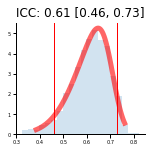

In [103]:

def bootstrap_ICC(var, animalList=animalList, num_bootstrap=1000, plot=False):
    icc_values = np.zeros(num_bootstrap)
    bootstrap_samples = []

    for _ in range(num_bootstrap):
        bootstrap_animals = np.random.choice(animalList, size=len(animalList), replace=True)
        bootstrap_sample = {animal: {} for animal in bootstrap_animals}
        
        for animal in bootstrap_animals:
            for cond, value in var[animal].items():
                bootstrap_sample[animal][cond] = value

        icc_values[_] = compute_ICC(bootstrap_sample, animalList=bootstrap_animals)[0]
        bootstrap_samples.append(bootstrap_sample)

    #fit skew normal
    a, loc, scale = stats.skewnorm.fit(icc_values)
    x = np.linspace(stats.skewnorm.ppf(0.01, a, loc, scale),
                    stats.skewnorm.ppf(0.99, a, loc, scale), 100)
    y = stats.skewnorm.pdf(x, a, loc, scale)

    lower_bound = np.percentile(icc_values, 5)
    upper_bound = np.percentile(icc_values, 95)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='skewnorm pdf')
        ax.hist(icc_values, bins=20, density=True, histtype='stepfilled', alpha=0.2)
        ax.axvline(lower_bound, color='red')
        ax.axvline(upper_bound, color='red')
        ax.set_title('ICC: {:.2f} [{:.2f}, {:.2f}]'.format(np.mean(icc_values), lower_bound, upper_bound))

    return icc_values


_ = bootstrap_ICC(alpha, animalList=animalList, num_bootstrap=1000, plot=True)

{'RatF00': {'60': 0.06314702199598787, '90': 0.08639825807038148, '120': 0.4417804900434434, '20': 0.6296372318020804, '10': 1.0083710458144801, '2': 0.4355222533529397, 'rev10': 0.8981533272732425, 'rev20': 0.9178568208946297}, 'RatF01': {'60': 1.3516982428218047, '90': 1.1418699135003363, '120': 1.8551947204420862, '20': 2.425404477395434, '10': 1.5420801161444277, '2': 2.3241918309185197, 'rev10': 2.2714550611782167, 'rev20': 2.092730497028224}, 'RatF02': {'60': 1.545701789777263, '90': 1.0367727822193344, '120': 1.0424818092496042, '20': 1.5015578312018327, '10': 1.332330840139376, '2': 2.040477697757612, 'rev10': 1.6158589039573126, 'rev20': 2.2426759370025406}, 'RatM00': {'60': 1.2995164809488777, '90': 0.9374836834077694, '120': 1.2706663248699346, '20': 1.2499671795009015, '10': 1.746867081273324, '2': 1.7453120894891414, 'rev10': 1.2353515927854808, 'rev20': 1.4923647111991198}, 'RatM01': {'60': 1.965951690436053, '90': 1.8741449029337884, '120': 1.3817936926187926, '20': 1.89

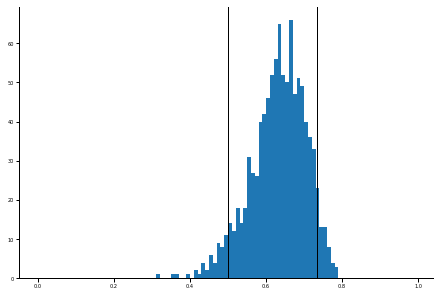

In [107]:
# not working
# now working but does the same as above
def generate_bootstrap_samples(var, intercept_variance, residual_variance, n=1000):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    samples = []
    for i in range(n):
        sample = {}
        for animal in animalList:
            rand1 = np.random.normal(0, np.sqrt(intercept_variance))
            sample[animal] = {}
            for cond in conds:
                expected = np.mean([var[animal][cond] for animal in animalList])
                rand2 = np.random.normal(0, np.sqrt(residual_variance))
                sample[animal][cond] = var[animal][cond] + rand1 + rand2
        samples.append(sample)
    return samples

n = 1000
ICCs = np.zeros(n)
samples = generate_bootstrap_samples(alpha,  
                                                    # 0, 0, 
                                                    0.08384340320952754, 0.05075930891342514,
                                                    # 0.09718749881658037, 0.03298486407655271, 
                                                    n=n)
print(samples[0])

for i, sample in enumerate(samples):
    ICC_pop, ICC_indiv = compute_ICC(sample)
    ICCs[i] = ICC_pop

conf_bottom = np.percentile(ICCs, 5)
conf_top = np.percentile(ICCs, 95)

plt.hist(ICCs, bins=np.arange(0, 1, 0.01))
plt.axvline(conf_bottom, color='black')
plt.axvline(conf_top, color='black')
print('IC', conf_bottom, conf_top)
# 0 RatF00 60 1.2839231268010671

NameError: name 'bootstrap_ICC' is not defined

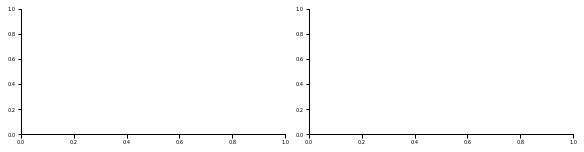

In [102]:
lesion = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42']
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = ('alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R')



fig, axs = plt.subplots(1, 2, figsize=(8, 2))

populationRi = {}
conf_bottom = {}
conf_top = {}
indivRi = {}
ICC_bootstrap = {}

for i, (var, name) in enumerate(zip(vars, names)):
    populationRi[name], indivRi[name] = compute_ICC(var, animalList=lesion)
    ICC_bootstrap[name] = bootstrap_ICC(var, animalList=lesion)
    conf_bottom[name], conf_top[name] = np.percentile(ICC_bootstrap[name], 5), np.percentile(ICC_bootstrap[name], 95)

for i, (var, name) in enumerate(zip(vars, names)):
    femalesRi = [indivRi[name][animal] for animal in lesion if 'F' in animal]
    malesRi = [indivRi[name][animal] for animal in lesion if 'M' in animal]

    print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
    print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

    for animal in lesion:
        axs[0].scatter(i, indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)

    line = 0.25/2
    axs[0].plot([i+.25-line, i+.25+line], [populationRi[name], populationRi[name]], color='gray', lw=0.5, zorder=1)
    axs[0].scatter(i+.25, populationRi[name], color='gray', s=2.5)

    violin_parts = axs[0].violinplot(positions=[i+.25], 
                    dataset=[ICC_bootstrap[name]],
                    widths=.33, showextrema=False, 
                    quantiles=[0.05, 0.95])
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(0)
        vp.set_alpha(.25)
        vp.set_zorder(0)
    # for vp in violin_parts['cquantiles']:
    violin_parts['cquantiles'].set_facecolor('gray')
    violin_parts['cquantiles'].set_edgecolor('gray')
    violin_parts['cquantiles'].set_linewidth(1)
    violin_parts['cquantiles'].set_alpha(.25)
    violin_parts['cquantiles'].set_zorder(1)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(0)
            vp.set_alpha(0)
        except:
            pass

for i, animal in enumerate(lesion):

    axs[1].scatter([i] * len([indivRi[name][animal] for name in names]),
                    [indivRi[name][animal] for name in names],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                    
    lower = np.percentile([indivRi[name][animal] for name in names], 5)
    upper = np.percentile([indivRi[name][animal] for name in names], 95)

    axs[1].errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                    yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                            [upper - np.median([indivRi[name][animal] for name in names])]],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                    capsize=5, capthick=1, elinewidth=1)


axs[0].set_xticks(range(len(vars)))
axs[0].set_xticklabels(names, rotation=90)
axs[0].set_ylabel('Ri')
axs[0].set_ylim(0, 1)
# axs[0].set_yticklabels('')
# axs[0].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[0].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[0].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[0].tick_params(which='minor', length=0)



axs[1].set_xticks(range(len(lesion)))
axs[1].set_xticklabels(lesion, rotation=90)
axs[1].set_ylabel('Overall Ri')
axs[1].set_ylim(0, 1)
# axs[1].set_yticklabels('')
# axs[1].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[1].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[1].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[1].tick_params(which='minor', length=0)


alpha M vs F p = 0.7058
alpha M vs F p = MannwhitneyuResult(statistic=105.0, pvalue=0.7471061995484956)
alpha_t M vs F p = 0.3108
alpha_t M vs F p = MannwhitneyuResult(statistic=123.0, pvalue=0.2494716685110525)
alpha_R M vs F p = 0.4756
alpha_R M vs F p = MannwhitneyuResult(statistic=88.0, pvalue=0.6784434641931191)
gamma M vs F p = 0.1565
gamma M vs F p = MannwhitneyuResult(statistic=62.0, pvalue=0.1068994924090607)
gamma_t M vs F p = 0.04
gamma_t M vs F p = MannwhitneyuResult(statistic=49.0, pvalue=0.02702638531408372)
gamma_R M vs F p = 0.255
gamma_R M vs F p = MannwhitneyuResult(statistic=75.0, pvalue=0.3108512029584284)
mu M vs F p = 0.9308
mu M vs F p = MannwhitneyuResult(statistic=102.0, pvalue=0.8538084126585609)
mu_t M vs F p = 0.877
mu_t M vs F p = MannwhitneyuResult(statistic=105.0, pvalue=0.7471061995484956)
mu_R M vs F p = 0.3399
mu_R M vs F p = MannwhitneyuResult(statistic=75.0, pvalue=0.3108512029584284)
sigma M vs F p = 0.9964
sigma M vs F p = MannwhitneyuResult(statis

(0.0, 1.0)

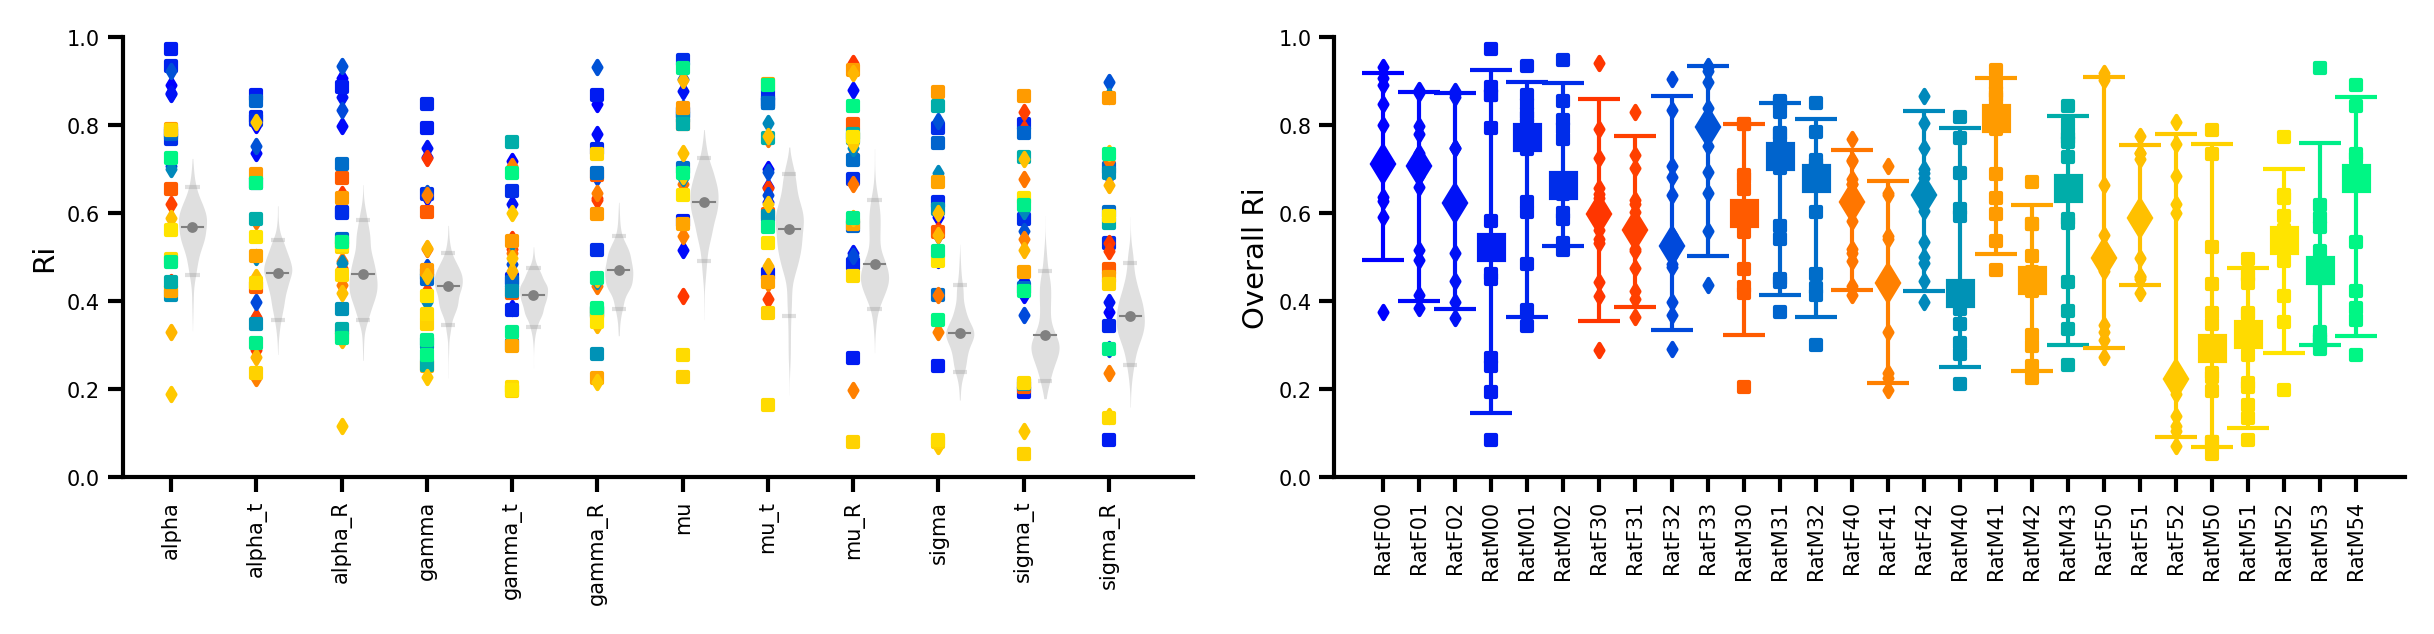

In [564]:
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = ('alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R')



fig, axs = plt.subplots(1, 2, figsize=(8, 2))

populationRi = {}
conf_bottom = {}
conf_top = {}
indivRi = {}
ICC_bootstrap = {}

for i, (var, name) in enumerate(zip(vars, names)):
    populationRi[name], indivRi[name] = compute_ICC(var)
    ICC_bootstrap[name] = bootstrap_ICC(var)
    conf_bottom[name], conf_top[name] = np.percentile(ICC_bootstrap[name], 5), np.percentile(ICC_bootstrap[name], 95)

for i, (var, name) in enumerate(zip(vars, names)):
    femalesRi = [indivRi[name][animal] for animal in animalList if 'F' in animal]
    malesRi = [indivRi[name][animal] for animal in animalList if 'M' in animal]

    print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
    print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

    for animal in animalList:
        axs[0].scatter(i, indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)

    line = 0.25/2
    axs[0].plot([i+.25-line, i+.25+line], [populationRi[name], populationRi[name]], color='gray', lw=0.5, zorder=1)
    axs[0].scatter(i+.25, populationRi[name], color='gray', s=2.5)

    violin_parts = axs[0].violinplot(positions=[i+.25], 
                    dataset=[ICC_bootstrap[name]],
                    widths=.33, showextrema=False, 
                    quantiles=[0.05, 0.95])
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(0)
        vp.set_alpha(.25)
        vp.set_zorder(0)
    # for vp in violin_parts['cquantiles']:
    violin_parts['cquantiles'].set_facecolor('gray')
    violin_parts['cquantiles'].set_edgecolor('gray')
    violin_parts['cquantiles'].set_linewidth(1)
    violin_parts['cquantiles'].set_alpha(.25)
    violin_parts['cquantiles'].set_zorder(1)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(0)
            vp.set_alpha(0)
        except:
            pass

for i, animal in enumerate(animalList):

    axs[1].scatter([i] * len([indivRi[name][animal] for name in names]),
                    [indivRi[name][animal] for name in names],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                    
    lower = np.percentile([indivRi[name][animal] for name in names], 5)
    upper = np.percentile([indivRi[name][animal] for name in names], 95)

    axs[1].errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                    yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                            [upper - np.median([indivRi[name][animal] for name in names])]],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                    capsize=5, capthick=1, elinewidth=1)


axs[0].set_xticks(range(len(vars)))
axs[0].set_xticklabels(names, rotation=90)
axs[0].set_ylabel('Ri')
axs[0].set_ylim(0, 1)
# axs[0].set_yticklabels('')
# axs[0].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[0].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[0].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[0].tick_params(which='minor', length=0)



axs[1].set_xticks(range(len(animalList)))
axs[1].set_xticklabels(animalList, rotation=90)
axs[1].set_ylabel('Overall Ri')
axs[1].set_ylim(0, 1)
# axs[1].set_yticklabels('')
# axs[1].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[1].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[1].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[1].tick_params(which='minor', length=0)


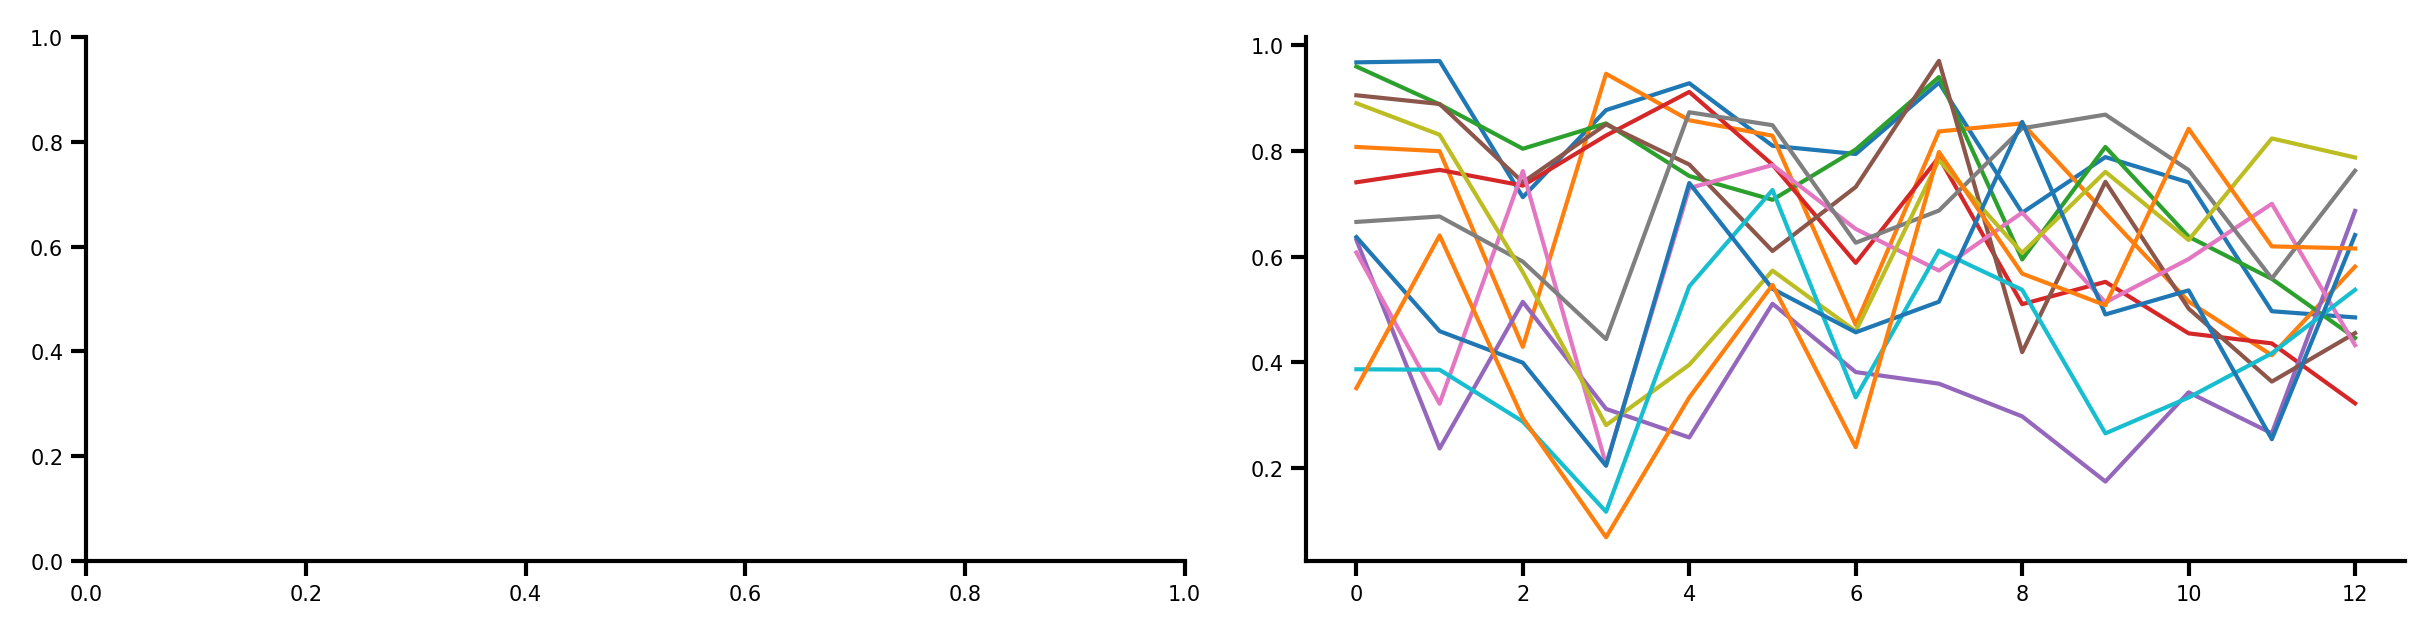

In [503]:
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = ('alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R')



fig, axs = plt.subplots(1, 2, figsize=(8, 2))


for i, (var, name) in enumerate(zip(vars, names)):
    x = np.arange(len(animalList))
    y = [indivRi[name][animal] for animal in animalList]
    axs[1].plot(x, y)

    
                    




In [803]:
# overall Ri differences between animals?
values = []
for key, rat_data in indivRi.items():
    values.append(list(rat_data.values()))

res = stats.kruskal(*values)
print(res)

KruskalResult(statistic=52.24056834884857, pvalue=2.466026605177779e-07)


In [805]:
# overalll Ri differences between animals?
values = []
for key, rat_data in indivRi.items():
    values.append(list(rat_data.values()))

# Perform normality test for each group
normality_passed = True
for group_values in values:
    _, p_value = stats.shapiro(group_values)
    print(stats.shapiro(group_values))
    if p_value < 0.05:
        normality_passed = False
        break

if normality_passed:
    f_statistic, p_value = stats.f_oneway(*values)
    
    print("F-statistic:", f_statistic)
    print("p-value:", p_value)

    if p_value < 0.05:
        print("There are significant differences between individuals.")
    else:
        print("There are no significant differences between individuals.")
else:
    print("The normality assumption is violated. Consider using non-parametric tests.")

# post hoc test
c=0
alpha = 0.05 / 78
for i, animal in enumerate(animalList):
    for j, animal2 in enumerate(animalList):
        if i < j:
            c+=1
            p_ttest = stats.ttest_ind([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names])[1]
            p_mann = stats.mannwhitneyu([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names])[1]
            p_ks = stats.ks_2samp([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names])[1]
            p_wilcoxon = stats.wilcoxon([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names])[1]
            p_perm = exact_mc_perm_test([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names], 1000)

            if p_ttest < alpha or p_mann < alpha or p_ks < alpha or p_wilcoxon < alpha or p_perm < alpha:

                print(animal, animal2)
                print(exact_mc_perm_test([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names], 1000))
                print(stats.ttest_ind([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names]))
                print(stats.mannwhitneyu([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names]))
                print(stats.ks_2samp([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names]))
                print(stats.wilcoxon([indivRi[name][animal] for name in names], [indivRi[name][animal2] for name in names]))
print(f'n comparisons: {c}')

ShapiroResult(statistic=0.9059577584266663, pvalue=0.16142801940441132)
ShapiroResult(statistic=0.8794867992401123, pvalue=0.07017853856086731)
ShapiroResult(statistic=0.9566210508346558, pvalue=0.700970470905304)
ShapiroResult(statistic=0.9400346875190735, pvalue=0.45735129714012146)
ShapiroResult(statistic=0.9167827367782593, pvalue=0.22691544890403748)
ShapiroResult(statistic=0.9315981268882751, pvalue=0.35756435990333557)
ShapiroResult(statistic=0.9071025848388672, pvalue=0.1673695594072342)
ShapiroResult(statistic=0.9416714906692505, pvalue=0.47890883684158325)
ShapiroResult(statistic=0.9355543851852417, pvalue=0.4019649624824524)
ShapiroResult(statistic=0.9764583110809326, pvalue=0.9576933979988098)
ShapiroResult(statistic=0.9734112024307251, pvalue=0.9313715696334839)
ShapiroResult(statistic=0.9655953049659729, pvalue=0.8367646932601929)
F-statistic: 7.028832753058896
p-value: 1.8585472458840567e-09
There are significant differences between individuals.


KeyError: 'RatF30'

In [85]:
# overalll Ri differences between male & female?
male_data = []
female_data = []

for key, rat_data in indivRi.items():
    male_data.extend([value for rat, value in rat_data.items() if rat.startswith('RatM')])
    female_data.extend([value for rat, value in rat_data.items() if rat.startswith('RatF')])

# Perform t-test for normally distributed data
t_statistic, p_value_t = stats.ttest_ind(male_data, female_data)

# Perform Mann-Whitney U test for non-normally distributed data
u_statistic, p_value_mw = stats.mannwhitneyu(male_data, female_data)

perm = exact_mc_perm_test(male_data, female_data, 10000)

print("T-test results:")
print("t-statistic:", t_statistic)
print("p-value (t-test):", p_value_t)

print("Mann-Whitney U test results:")
print("U-statistic:", u_statistic)
print("p-value (Mann-Whitney U):", p_value_mw)

print("Permutation test results:")
print("p-value (permutation test):", perm)


alpha = 0.05

if p_value_t < alpha:
    print("There are significant differences between male and female rats (t-test).")
else:
    print("There are no significant differences between male and female rats (t-test).")

if p_value_mw < alpha:
    print("There are significant differences between male and female rats (Mann-Whitney U test).")
else:
    print("There are no significant differences between male and female rats (Mann-Whitney U test).")

if perm < alpha:
    print("There are significant differences between male and female rats (perm test).")
else:
    print("There are no significant differences between male and female rats (perm test).")


T-test results:
t-statistic: -1.2179476264605502
p-value (t-test): 0.22510664508150702
Mann-Whitney U test results:
U-statistic: 2729.0
p-value (Mann-Whitney U): 0.29512901789538615
Permutation test results:
p-value (permutation test): 0.2252
There are no significant differences between male and female rats (t-test).
There are no significant differences between male and female rats (Mann-Whitney U test).
There are no significant differences between male and female rats (perm test).


 corr: 0.69, p: 0.0094
 corr: -0.52, p: 0.0685
 corr: -0.02, p: 0.9539


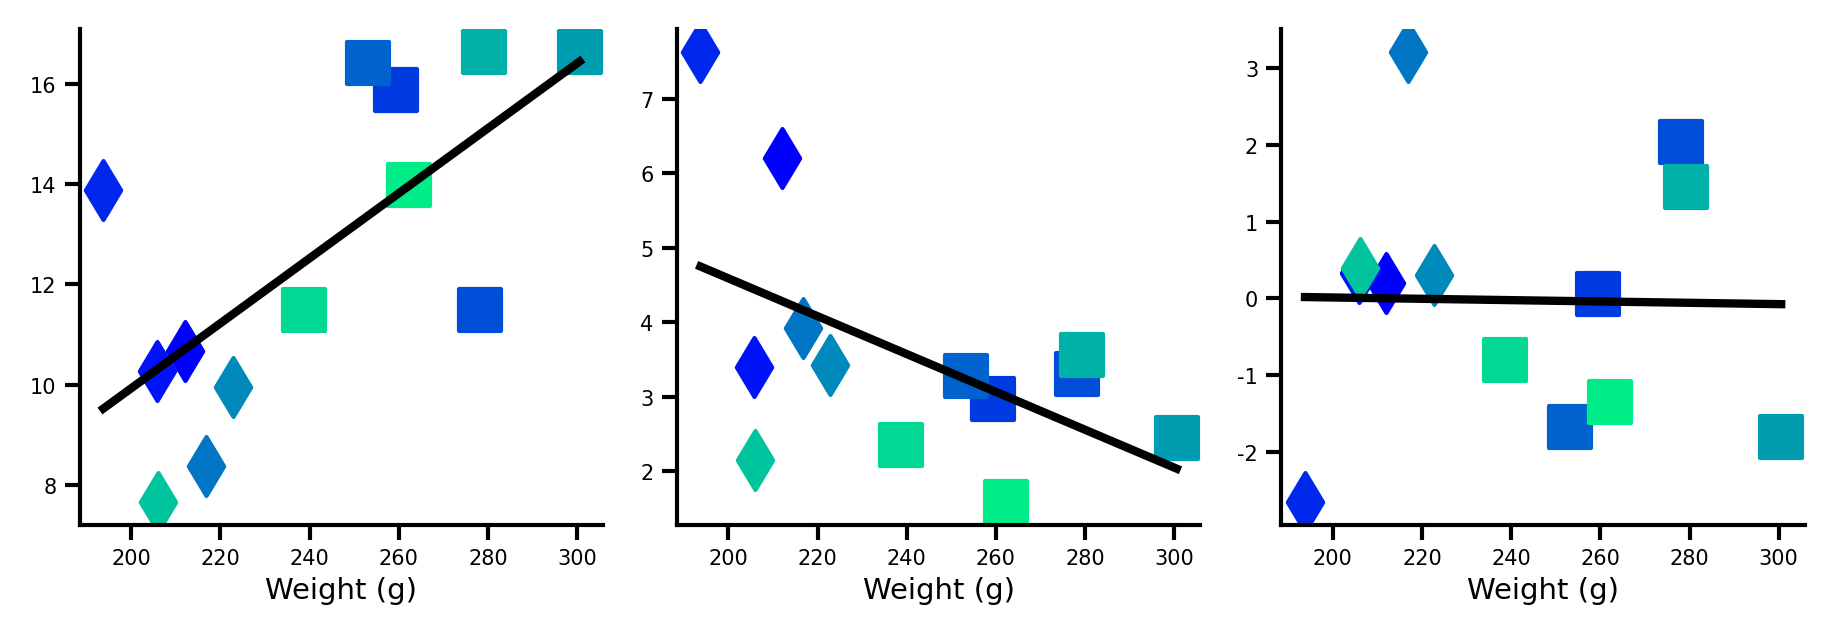

In [242]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}


epsilon_0, epsilon_t, epsilon_R = pickle.load(open("picklejar/effort_fit.p", "rb"))
epss = [epsilon_0, epsilon_t, epsilon_R]

fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for j, var in enumerate(epss):
    _x, _y = [], []
    for animal in animalList:
        # zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = var[animal]
        x = weights[animal]
        # y /= x

        ax[j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[j].set_xlabel("Weight (g)")
        # ax[j].set_ylabel(ylabelsIDLE[j])
        # ax[j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)


In [240]:
epsilon_0, epsilon_t, epsilon_R = pickle.load(open("picklejar/effort_fit.p", "rb"))

epsilon_0_Males = [epsilon_0[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_0_Females = [epsilon_0[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_t_Males = [epsilon_t[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_t_Females = [epsilon_t[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_R_Males = [epsilon_R[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_R_Females = [epsilon_R[animal] for animal in animalList if animal.startswith('RatF')]


perm_0 = exact_mc_perm_test(epsilon_0_Males, epsilon_0_Females, 10000)
perm_t = exact_mc_perm_test(epsilon_t_Males, epsilon_t_Females, 10000)
perm_R = exact_mc_perm_test(epsilon_R_Males, epsilon_R_Females, 10000)

alpha = 0.05 / 3

print("Permutation test results:")
print("p-value (permutation test) 0:", perm_0, perm_0 < alpha)
print("p-value (permutation test) t:", perm_t, perm_t < alpha)
print("p-value (permutation test) R:", perm_R, perm_R < alpha)





epsilon_0_Males = [epsilon_0[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_0_Females = [epsilon_0[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_t_Males = [epsilon_t[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_t_Females = [epsilon_t[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]

epsilon_R_Males = [epsilon_R[animal]/weights[animal] for animal in animalList if animal.startswith('RatM')]
epsilon_R_Females = [epsilon_R[animal]/weights[animal] for animal in animalList if animal.startswith('RatF')]


perm_0 = exact_mc_perm_test(epsilon_0_Males, epsilon_0_Females, 10000)
perm_t = exact_mc_perm_test(epsilon_t_Males, epsilon_t_Females, 10000)
perm_R = exact_mc_perm_test(epsilon_R_Males, epsilon_R_Females, 10000)

alpha = 0.05 / 3

print("Permutation test results, controling weight:")
print("p-value (permutation test) 0:", perm_0, perm_0 < alpha)
print("p-value (permutation test) t:", perm_t, perm_t < alpha)
print("p-value (permutation test) R:", perm_R, perm_R < alpha)

print(alpha)


Permutation test results:
p-value (permutation test) 0: 0.0068 True
p-value (permutation test) t: 0.0529 False
p-value (permutation test) R: 0.5343 False
Permutation test results, controling weight:
p-value (permutation test) 0: 0.3043 False
p-value (permutation test) t: 0.0027 True
p-value (permutation test) R: 0.5782 False
0.016666666666666666


Permutation test results:
p-value (permutation test) 0: 0.0076 True
p-value (permutation test) t: 0.0539 False
p-value (permutation test) R: 0.5252 False


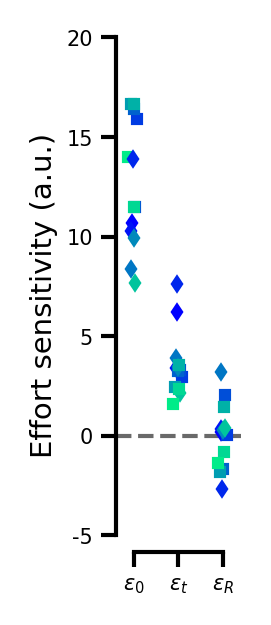

In [227]:
# epsilons distribution
# in fig 5

weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}



def Figure3X(ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for animal in animalList:
        zorder=2
        if animal == 'RatF02':
            zorder = 10

        x = np.random.normal(0, 0.05)
        ax.plot(np.arange(3)+x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], 
                    color=rat_markers[animal][0], label=animal, 
                    marker=rat_markers[animal][1], markersize=2, lw=0, zorder=zorder)
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels([r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"])
    ax.set_xlim(0, 2)
    ax.set_ylim(-5, 20)
    ax.set_ylabel(f'Effort sensitivity (a.u.)')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, x_ratio_left=.2, x_ratio_right=.2)


fig, axs = plt.subplots(1, 1, figsize=(cm2inch(2), cm2inch(5)))
Figure3X(axs)

(0.0, 1.0)

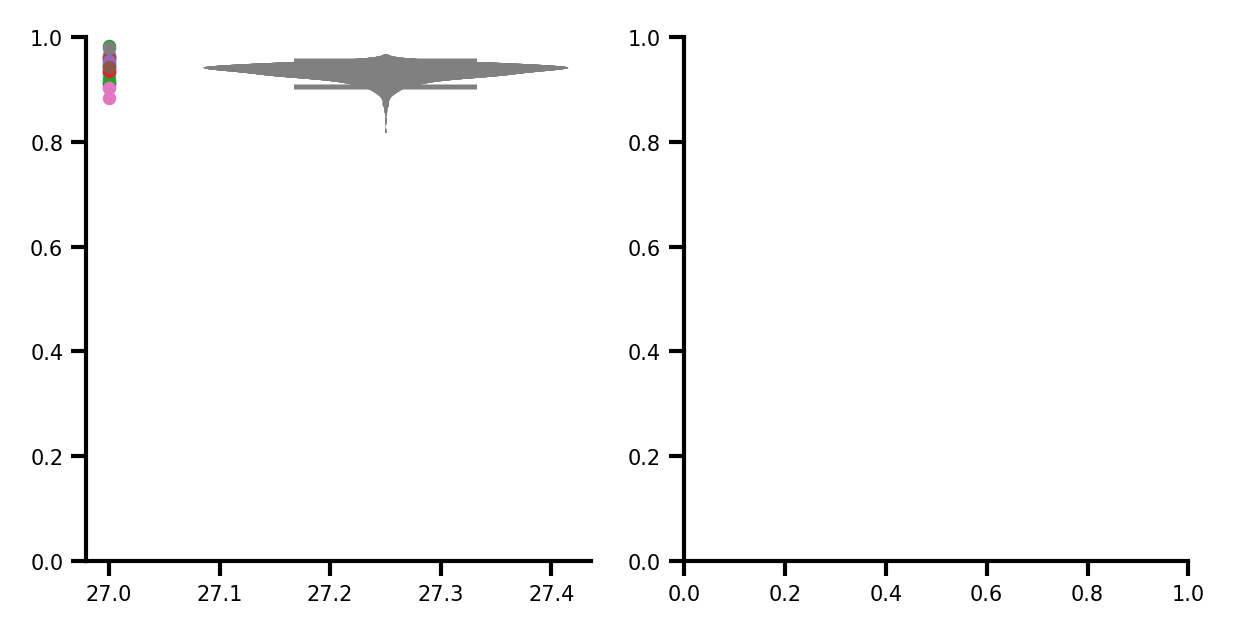

In [570]:
def do_stuff(var, name='', animalList=animalList):
    fig, axs = plt.subplots(1, 2, figsize=(2, 2), gridspec_kw={'width_ratios': [1, .5]})

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:

        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        axs[0].plot(x, y, label=animal, marker='o', markersize=2)


        #############################""
        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])




        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        remaining_residuals[animal] = np.var(y_corrected)

        temp_ymax = np.max(y)
        if temp_ymax > ymax:
            ymax = temp_ymax

    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    ICC_pop = alp / (alp + eps)

    axs[0].set_ylabel("Value (a.u.)")
    axs[0].set_xticks(x)
    axs[0].set_xlabel("Measurement #")
    axs[0].set_xlim(0, 7)
    axs[0].set_ylim(0, 1.1*ymax)
    space_axes(axs[0], x_ratio_left=.1, x_ratio_right=.1)
    axs[0].set_yticks([])
    axs[0].set_yticklabels([])



    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])
        axs[1].scatter(0,  ICC_indiv[animal], s=5)
    


    # compute_ICC(var)
    conf_bottom, conf_top = bootstrap_ICC(var, animalList, num_bootstrap=1000 )
    axs[1].scatter(0.1, ICC_pop, color='r', s=5)
    axs[1].errorbar(0.1, ICC_pop, yerr=[[ICC_pop - conf_bottom], [conf_top - ICC_pop]], color='r', capsize=5, capthick=1)
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(0, 0.1)
    axs[1].set_xticks([0, 0.1])
    axs[1].set_xticklabels([r"$\mathrm{ICC_{ind}}$", r"$\mathrm{ICC_{pop}}$"])
    axs[1].set_ylabel("Repeatability")
    space_axes(axs[1], x_ratio_left=.5, x_ratio_right=.5)
    
    
    plt.show()


    




def mock_dataset(n_subjects=animalList, n_measurements=["60", "90", "120", "rev20", "rev10", "2", "10", "20"], noise=0):
    np.random.seed(2007)
    data = {}
    expected_value = np.arange(len(n_measurements))/10+ np.random.rand(len(n_measurements))/5
    expected_value *= 0
    individual_intercept = np.random.rand(len(n_subjects))

    for i, animal in enumerate(n_subjects):
        data[animal] = {}
        # for j in range(len(n_measurements)):
        for j, cond in enumerate(n_measurements):
            data[animal][cond] = expected_value[j] + individual_intercept[i] + np.random.rand() * noise
    return data

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
var = mock_dataset(noise=0.25)
populationRi, indivRi = compute_ICC(var)
ICC_bootstrap = bootstrap_ICC(var)
conf_bottom, conf_top = np.percentile(ICC_bootstrap, 5), np.percentile(ICC_bootstrap, 95)

for animal in animalList:
    axs[0].scatter(i, indivRi[animal], s=5)

    line = 0.25/2
    axs[0].plot([i+.25-line, i+.25+line], [populationRi, populationRi], color='gray', lw=0.5, zorder=1)
    axs[0].scatter(i+.25, populationRi, color='gray', s=2.5)

    violin_parts = axs[0].violinplot(positions=[i+.25], 
                    dataset=[ICC_bootstrap],
                    widths=.33, showextrema=False, 
                    quantiles=[0.05, 0.95])
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(0)
        vp.set_alpha(.25)
        vp.set_zorder(0)
    # for vp in violin_parts['cquantiles']:
    violin_parts['cquantiles'].set_facecolor('gray')
    violin_parts['cquantiles'].set_edgecolor('gray')
    violin_parts['cquantiles'].set_linewidth(1)
    violin_parts['cquantiles'].set_alpha(.25)
    violin_parts['cquantiles'].set_zorder(1)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(0)
            vp.set_alpha(0)
        except:
            pass

# for i, animal in enumerate(animalList):

#     axs[1].scatter([i] * len([indivRi[name][animal] for name in names]),
#                     [indivRi[name][animal] for name in names],
#                     color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                    
#     lower = np.percentile([indivRi[name][animal] for name in names], 5)
#     upper = np.percentile([indivRi[name][animal] for name in names], 95)

#     axs[1].errorbar(i, np.median([indivRi[name][animal] for name in names]), 
#                     yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
#                             [upper - np.median([indivRi[name][animal] for name in names])]],
#                     color=rat_markers[animal][0], marker=rat_markers[animal][1], 
#                     capsize=5, capthick=1, elinewidth=1)


# axs[0].set_xticks(range(len(vars)))
# axs[0].set_xticklabels(names, rotation=90)
# axs[0].set_ylabel('Ri')
axs[0].set_ylim(0, 1)
# # axs[0].set_yticklabels('')
# # axs[0].set_yticks([0, 0.5, 0.75, .9, 1])
# # axs[0].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# # axs[0].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# # axs[0].tick_params(which='minor', length=0)



# axs[1].set_xticks(range(len(animalList)))
# axs[1].set_xticklabels(animalList, rotation=90)
# axs[1].set_ylabel('Overall Ri')
# axs[1].set_ylim(0, 1)
# axs[1].set_yticklabels('')
# axs[1].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[1].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[1].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[1].tick_params(which='minor', length=0)




# N = 6
# do_stuff(mock_dataset(noise=0.25), '', animalList=animalList[:N])
# do_stuff(mock_dataset(noise=1.5), '', animalList=animalList[:N])

ValueError: too many values to unpack (expected 2)

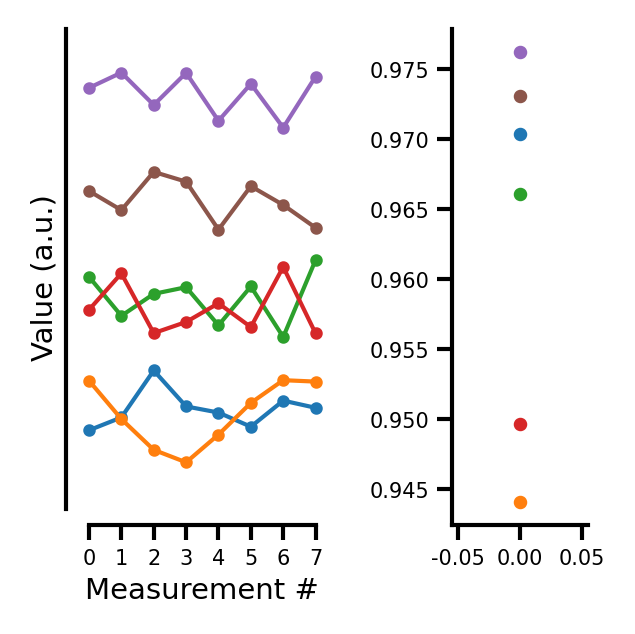

In [571]:
N = 6
do_stuff(mock_dataset(noise=0.25), '', animalList=animalList[:N])
do_stuff(mock_dataset(noise=1.5), '', animalList=animalList[:N])

In [ ]:


fig, axs = plt.subplots(1, 2, figsize=(8, 2))

populationRi = {}
conf_bottom = {}
conf_top = {}
indivRi = {}
ICC_bootstrap = {}

for i, (var, name) in enumerate(zip(vars, names)):
    populationRi, indivRi = compute_ICC(var)
    ICC_bootstrap = bootstrap_ICC(var)
    conf_bottom, conf_top = np.percentile(ICC_bootstrap, 5), np.percentile(ICC_bootstrap, 95)

for i, (var, name) in enumerate(zip(vars, names)):
    femalesRi = [indivRi[name][animal] for animal in animalList if 'F' in animal]
    malesRi = [indivRi[name][animal] for animal in animalList if 'M' in animal]

    print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
    print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

    for animal in animalList:
        axs[0].scatter(i, indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)

    line = 0.25/2
    axs[0].plot([i+.25-line, i+.25+line], [populationRi[name], populationRi[name]], color='gray', lw=0.5, zorder=1)
    axs[0].scatter(i+.25, populationRi[name], color='gray', s=2.5)

    violin_parts = axs[0].violinplot(positions=[i+.25], 
                    dataset=[ICC_bootstrap[name]],
                    widths=.33, showextrema=False, 
                    quantiles=[0.05, 0.95])
    
    for vp in violin_parts['bodies']:
        vp.set_facecolor('gray')
        vp.set_edgecolor('gray')
        vp.set_linewidth(0)
        vp.set_alpha(.25)
        vp.set_zorder(0)
    # for vp in violin_parts['cquantiles']:
    violin_parts['cquantiles'].set_facecolor('gray')
    violin_parts['cquantiles'].set_edgecolor('gray')
    violin_parts['cquantiles'].set_linewidth(1)
    violin_parts['cquantiles'].set_alpha(.25)
    violin_parts['cquantiles'].set_zorder(1)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(0)
            vp.set_alpha(0)
        except:
            pass

for i, animal in enumerate(animalList):

    axs[1].scatter([i] * len([indivRi[name][animal] for name in names]),
                    [indivRi[name][animal] for name in names],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                    
    lower = np.percentile([indivRi[name][animal] for name in names], 5)
    upper = np.percentile([indivRi[name][animal] for name in names], 95)

    axs[1].errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                    yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                            [upper - np.median([indivRi[name][animal] for name in names])]],
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                    capsize=5, capthick=1, elinewidth=1)


axs[0].set_xticks(range(len(vars)))
axs[0].set_xticklabels(names, rotation=90)
axs[0].set_ylabel('Ri')
axs[0].set_ylim(0, 1)
# axs[0].set_yticklabels('')
# axs[0].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[0].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[0].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[0].tick_params(which='minor', length=0)



axs[1].set_xticks(range(len(animalList)))
axs[1].set_xticklabels(animalList, rotation=90)
axs[1].set_ylabel('Overall Ri')
axs[1].set_ylim(0, 1)
# axs[1].set_yticklabels('')
# axs[1].set_yticks([0, 0.5, 0.75, .9, 1])
# axs[1].set_yticks([0.25, 0.625, 0.825, .95], minor=True)
# axs[1].set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
# axs[1].tick_params(which='minor', length=0)


# archetypes

In [716]:
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54'
                ]


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [766]:
# https://github.com/atmguille/archetypal-analysis/

In [574]:
from abc import ABC, abstractmethod
class AA_Abstract(ABC):

    def __init__(self, n_archetypes: int, max_iter: int = 100, tol: float = 1e-6, verbose: bool = False):
        self.n_archetypes = n_archetypes
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.Z = None  # Archetypes
        self.n_samples, self.n_features = None, None
        self.RSS = None

    def fit(self, X: np.ndarray) -> 'AA_Abstract':
        """
        Computes the archetypes and the RSS from the data X, which are stored
        in the corresponding attributes
        :param X: data matrix, with shape (n_samples, n_features)
        :return: self
        """
        self.n_samples, self.n_features = X.shape
        self._fit(X)
        return self

    def _fit(self, X: np.ndarray):
        """
        Internal function that computes the archetypes and the RSS from the data X
        :param X: data matrix, with shape (n_samples, n_features)
        :return: None
        """
        # Initialize the archetypes
        B = np.eye(self.n_archetypes, self.n_samples)
        Z = B @ X

        A = np.eye(self.n_samples, self.n_archetypes)
        prev_RSS = None

        for _ in range(self.max_iter):
            A = self._computeA(X, Z, A)
            B = self._computeB(X, A, B)
            Z = B @ X
            RSS = self._rss(X, A, Z)
            if prev_RSS is not None and abs(prev_RSS - RSS) / prev_RSS < self.tol:
                break
            prev_RSS = RSS

        self.Z = Z
        self.RSS = RSS

    @staticmethod
    @abstractmethod
    def _computeA(X: np.ndarray, Z: np.ndarray, A: np.ndarray = None) -> np.ndarray:
        """
        Updates the A matrix given the data matrix X and the archetypes Z.
        A is the matrix that gives the best convex approximation of X by Z,
        so this function can be used during training and inference.
        For the latter, use the transform method instead
        :param X: data matrix, with shape (n_samples, n_features)
        :param Z: archetypes matrix, with shape (n_archetypes, n_features)
        :param A: A matrix, with shape (n_samples, n_archetypes)
        :return: A matrix, with shape (n_samples, n_archetypes)
        """
        pass

    @staticmethod
    @abstractmethod
    def _computeB(X: np.ndarray, A: np.ndarray, B: np.ndarray = None) -> np.ndarray:
        """
        Updates the B matrix given the data matrix X and the A matrix
        :param X: data matrix, with shape (n_samples, n_features)
        :param A: A matrix, with shape (n_samples, n_archetypes)
        :param B: B matrix, with shape (n_archetypes, n_samples)
        :return: B matrix, with shape (n_archetypes, n_samples)
        """
        pass

    def archetypes(self) -> np.ndarray:
        """
        Returns the archetypes' matrix
        :return: archetypes matrix, with shape (n_archetypes, n_features)
        """
        return self.Z

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Computes the best convex approximation A of X by the archetypes
        :param X: data matrix, with shape (n_samples, n_features)
        :return: A matrix, with shape (n_samples, n_archetypes)
        """
        return self._computeA(X, self.Z)

    @staticmethod
    def _rss(X: np.ndarray, A: np.ndarray, Z: np.ndarray) -> float:
        """
        Computes the RSS of the data matrix X, given the A matrix and the archetypes Z
        :param X: data matrix, with shape (n_samples, n_features)
        :param A: A matrix, with shape (n_samples, n_archetypes)
        :param Z: archetypes matrix, with shape (n_archetypes, n_features)
        :return: RSS
        """
        return np.linalg.norm(X - A @ Z)**2


class AA_Fast(AA_Abstract):

    def __init__(self, n_archetypes: int, max_iter: int = 100, tol: float = 1e-6, verbose: bool = False,
                 derivative_max_iter: int = 10):
        super().__init__(n_archetypes, max_iter, tol, verbose)
        self.derivative_max_iter = derivative_max_iter

    def _computeA(self, X: np.ndarray, Z: np.ndarray, A: np.ndarray = None) -> np.ndarray:
        A = np.zeros((self.n_samples, self.n_archetypes))
        A[:, 0] = 1.0
        e = np.zeros(A.shape)
        for t in range(self.derivative_max_iter):
            # brackets are VERY important to save time
            G = 2.0 * (A @ (Z @ Z.T) - X @ Z.T)
            # Get the argument mins along each column
            argmins = np.argmin(G, axis=1)
            e[range(self.n_samples), argmins] = 1.0
            A += 2.0 / (t + 2.0) * (e - A)
            e[range(self.n_samples), argmins] = 0.0
        return A

    def _computeB(self, X: np.ndarray, A: np.ndarray, B: np.ndarray = None) -> np.ndarray:
        B = np.zeros((self.n_archetypes, self.n_samples))
        B[:, 0] = 1.0
        e = np.zeros(B.shape)
        for t in range(self.derivative_max_iter):
            # brackets are VERY important to save time
            t1 = (A.T @ A) @ (B @ X) @ X.T
            t2 = (A.T @ X) @ X.T
            G = 2.0 * (t1 - t2)
            argmins = np.argmin(G, axis=1)
            e[range(self.n_archetypes), argmins] = 1.0
            B += 2.0 / (t + 2.0) * (e - B)
            e[range(self.n_archetypes), argmins] = 0.0
        return B

In [566]:
n_samples = 100
n_features = 12
data = np.random.rand(n_samples, n_features)
data.shape

(100, 12)

In [717]:
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
n_features = 12
# data = np.array((len(animalList)*len(conds), n_features))
# data
data = []
data_avg = []
labels = []
labels_avg = []

for animal in animalList:
    data_avg.append((np.mean([alpha[animal][cond] for cond in conds]), np.mean([alpha_t[animal][cond] for cond in conds]), np.mean([alpha_R[animal][cond] for cond in conds]), np.mean([gamma[animal][cond] for cond in conds]), np.mean([gamma_t[animal][cond] for cond in conds]), np.mean([gamma_R[animal][cond] for cond in conds]), np.mean([mu[animal][cond] for cond in conds]), np.mean([mu_t[animal][cond] for cond in conds]), np.mean([mu_R[animal][cond] for cond in conds]), np.mean([sigma[animal][cond] for cond in conds]), np.mean([sigma_t[animal][cond] for cond in conds]), np.mean([sigma_R[animal][cond] for cond in conds])))
    labels_avg.append(animal)
    for cond in conds:
        data.append((alpha[animal][cond], alpha_t[animal][cond], alpha_R[animal][cond], gamma[animal][cond], gamma_t[animal][cond], gamma_R[animal][cond], mu[animal][cond], mu_t[animal][cond], mu_R[animal][cond], sigma[animal][cond], sigma_t[animal][cond], sigma_R[animal][cond]))
        labels.append(animal)
data = np.array(data)
data_avg = np.array(data_avg)

print(data.shape)
print(data_avg.shape)

(224, 12)
(28, 12)


In [718]:
# https://github.com/nichohelmut/football_results/tree/3b4f5b7ab72e31298a61e8b7116817f6180c5102
def proc(data):
    model = AA_Fast(n_archetypes=3, max_iter=1000, tol=1e-6, verbose=True)
    archs = model.fit(data)
    return archs

def transform(data):
    A = proc(data).transform(data)
    return A

s = transform(data)
s.shape

(224, 3)

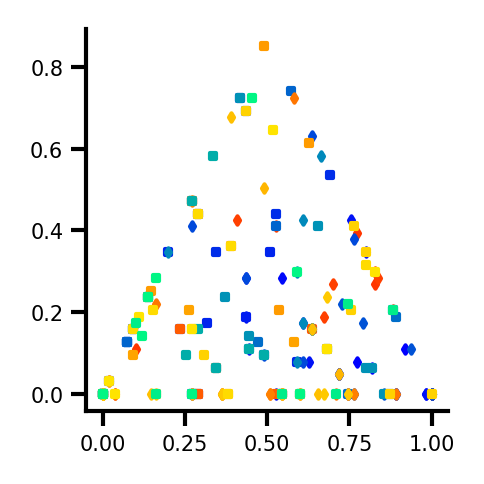

In [719]:
def scatter_triangle(points, labels=None, ax=None, vmin=0, vmax=1):

    if ax is None:
        fig, ax = plt.subplots(figsize=(1.5, 1.5))

    def _project(p):
        a = p[0]
        b = p[1]
        x = a + b/2
        y = np.sqrt(3) / 2  * b
        return np.array([x, y])

    x, y = list(zip(*[_project(p) for p in points]))

    for i in range(len(x)):
        if labels is None:
            ax.scatter(x[i], y[i], s=2, color='black')
        else:
            ax.scatter(x[i], y[i], s=2, color=rat_markers[labels[i]][0], marker=rat_markers[labels[i]][1])

scatter_triangle(s, labels)

In [720]:
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54'
                ]



# intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']
# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']

Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}


Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}


traits = {animal: [] for animal in animalList}
traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        traits[animal].append(np.mean(zscores))

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        traits[animal].append(np.mean(zscores))

traits

{'RatF00': [-1.6220557507948534,
  0.2971285167780656,
  1.1107160376893925,
  -1.1790575992040784,
  0.1941245637091082,
  0.9028997415262325,
  -0.3470840822294373,
  1.334610662347755,
  0.11371597145212703,
  0.8957429829697527,
  1.3289211318370449,
  0.4629757173449996],
 'RatF01': [-0.6190845872552522,
  1.0161420374011214,
  0.6174253018521023,
  -0.7675257711805268,
  -0.18935096055361467,
  0.772231998019434,
  -0.43797834159637516,
  0.07450951416417964,
  0.17342326378155593,
  -0.4390862438110734,
  0.8920160920132144,
  0.5382947864004133],
 'RatF02': [-0.30952783006830287,
  1.7137377098122057,
  0.7743869369964698,
  -0.6709385444352953,
  0.27203117004767197,
  0.5630185437573327,
  0.04966362920711615,
  2.218750625901683,
  -1.4470520289567859,
  0.9863687838877023,
  1.0684214791327764,
  -1.3697024081060887],
 'RatM00': [1.6503428837468594,
  0.10207757694499586,
  -1.4153638870639103,
  0.42652029525472757,
  0.7568916627422103,
  -0.6771981909936544,
  0.30066475

In [721]:
n_features = 12
data = []
data_avg = []
labels = []
labels_avg = []

for animal in animalList:
    data_avg.append(traits[animal])
    labels_avg.append(animal)
    for cond in conds:
        data.append((Zalpha[animal][cond], Zalpha_t[animal][cond], Zalpha_R[animal][cond], Zgamma[animal][cond], Zgamma_t[animal][cond], Zgamma_R[animal][cond], Zmu[animal][cond], Zmu_t[animal][cond], Zmu_R[animal][cond], Zsigma[animal][cond], Zsigma_t[animal][cond], Zsigma_R[animal][cond]))
        labels.append(animal)
data = np.array(data)
data_avg = np.array(data_avg)

print(data.shape)
print(data_avg.shape)

(224, 12)
(28, 12)


In [722]:

s = transform(data)
ss = transform(data_avg)

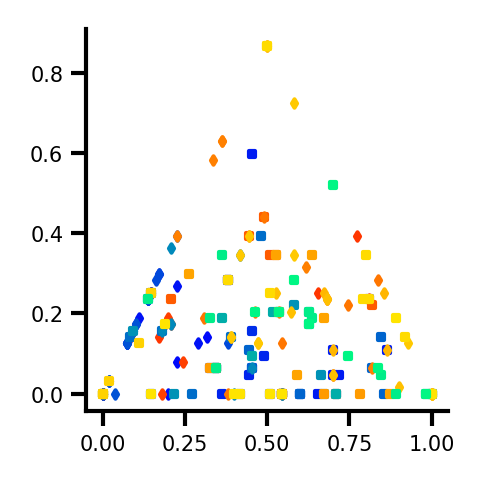

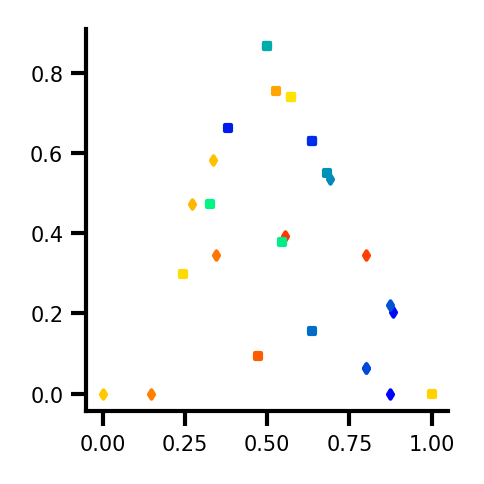

In [723]:
scatter_triangle(s, labels)
scatter_triangle(ss, labels_avg)

# PCA CLEAN

In [399]:
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']
            
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54'
                ]
            
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = 'alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R'

vars = alpha, alpha_t, gamma, gamma_t, gamma_R, mu, mu_t, sigma,
names = 'alpha', 'alpha_t', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'sigma'

In [400]:
def compute_intercept(var, animalList=animalList):


    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    x = np.arange(len(conds))


    for animal in animalList:

        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        #############################""
        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept
    return individual_intercepts

compute_intercept(mu)
# do_stuff(sigma)
# do_stuff(alpha, 'alpha')

{'RatF00': -0.10450672399125893,
 'RatF01': -0.1243085991053571,
 'RatF02': -0.05574701614002346,
 'RatM00': -0.02957552401451387,
 'RatM01': -0.1096449376108816,
 'RatM02': 0.0005137743002029381,
 'RatF30': 0.03082810047354827,
 'RatF31': -0.1321449786367784,
 'RatF32': -0.16481601849418454,
 'RatF33': -0.12615440725072943,
 'RatM30': 0.13536691079800436,
 'RatM31': 0.0008222950487000161,
 'RatM32': 0.03430522414176353,
 'RatF40': 0.12376039062847619,
 'RatF41': 0.3702226444390667,
 'RatF42': -0.22572018979999517,
 'RatM40': -0.13233168859988886,
 'RatM41': -0.13851304754465318,
 'RatM42': 0.0006248822713828567,
 'RatM43': -0.08916254492734434,
 'RatF50': 0.20830746125754937,
 'RatF51': 0.11414694171899493,
 'RatF52': 0.23035562670833531,
 'RatM50': -0.1427786591531257,
 'RatM51': 0.11052953942231017,
 'RatM52': 0.03176779565435367,
 'RatM53': 0.14471451361934332,
 'RatM54': 0.039138234786705556}

In [432]:
df = pd.DataFrame(index=intact)

for var, name in zip(vars, names):
    l = np.array(list(compute_intercept(var, intact).values()))
    df[name] = l / np.std(l)  # normalize by std to have a mean of 0 and std of 1
    print(name, np.mean(l), np.std(l), np.std(l / np.std(l)))

print(df.head())

# df to array
data = df.to_numpy()
labels = df.index.to_numpy()
variables = df.columns.to_numpy()
print(labels)

alpha -7.401486830834377e-18 0.3072705270016046 0.9999999999999998
alpha_t -3.7007434154171884e-18 0.06340425893533076 1.0
alpha_R -1.0177044392397268e-17 0.10322174109121302 1.0
gamma -5.551115123125783e-17 0.19766851251217596 1.0
gamma_t -9.251858538542971e-19 0.016576111085099918 0.9999999999999999
gamma_R -7.401486830834377e-18 0.07131577027902372 0.9999999999999999
mu 9.251858538542971e-19 0.09176201500317431 1.0
mu_t 2.3129646346357427e-18 0.022322756701435763 1.0
mu_R 0.0 0.02908217306272269 1.0
sigma 8.673617379884035e-19 0.013855308411066233 0.9999999999999999
sigma_t 3.4694469519536144e-19 0.007724439341346578 0.9999999999999999
sigma_R 1.7347234759768072e-19 0.008170678220295904 0.9999999999999999
           alpha   alpha_t   alpha_R     gamma   gamma_t   gamma_R        mu  \
RatF00 -1.914221  0.386289  1.355656 -1.616920  0.227449  1.164140 -0.454166   
RatF01 -0.752804  1.249264  0.766233 -1.044358 -0.282957  1.017752 -0.669962   
RatF02 -0.288358  2.188010  0.916818 -0.89

In [453]:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

pca = PCA(n_components=3) # estimate only 2 PCs
X_new = pca.fit_transform(data) # project the original data into the PCA space

In [454]:
# v = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
#         r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]

# v = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
#         r'$\mu_0$', r"$\mu_t$", r'$\sigma_0$']

print(abs( pca.components_ ))
# importance of each feature for PC1 and PC2

[[0.36848544 0.27690103 0.39326709 0.4051355  0.21588415 0.39823012
  0.1985247  0.27872184 0.04905513 0.01909472 0.36305271 0.10900059]
 [0.04046989 0.2624136  0.05334624 0.01679536 0.24110622 0.10051142
  0.20681775 0.40439907 0.47070534 0.37593645 0.17057933 0.50974248]
 [0.16525271 0.0140919  0.02122018 0.11990239 0.14805718 0.08438465
  0.27364894 0.22151042 0.51001882 0.64506556 0.21392165 0.28754571]]


0.0005
0.8445
0.9144


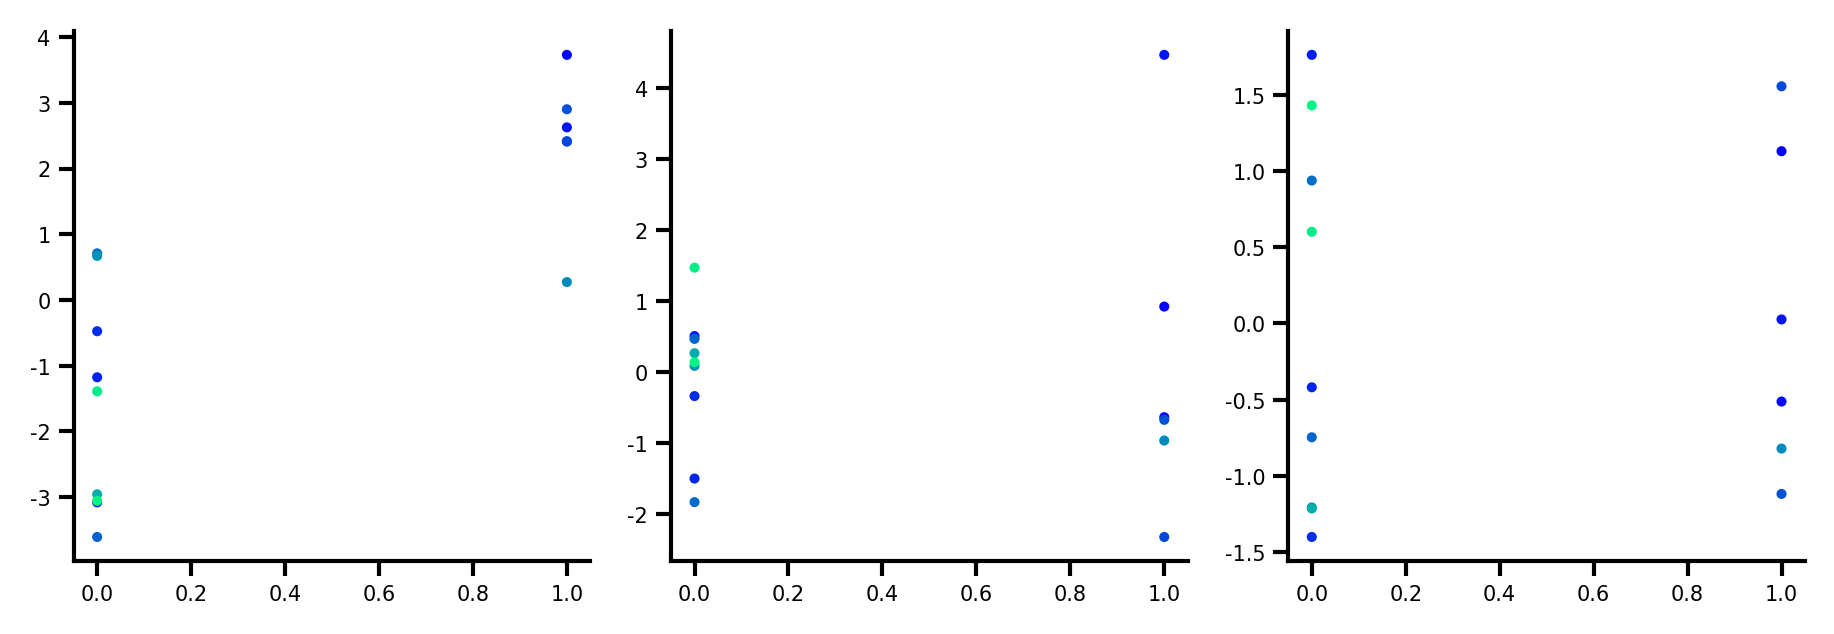

In [455]:
PC1_M, PC1_F = [], []
PC2_M, PC2_F = [], []
PC3_M, PC3_F = [], []

for animal, loadings in zip(labels, X_new):
    if animal[3] == 'M':
        PC1_M.append(loadings[0])
        PC2_M.append(loadings[1])
        PC3_M.append(loadings[2])
    else:
        PC1_F.append(loadings[0])
        PC2_F.append(loadings[1])
        PC3_F.append(loadings[2])


fig, axs = plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True)
axs[0].scatter([0]*len(PC1_M), PC1_M, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'M'], s=2)
axs[0].scatter([1]*len(PC1_F), PC1_F, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'F'], s=2)

axs[1].scatter([0]*len(PC2_M), PC2_M, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'M'],  s=2)
axs[1].scatter([1]*len(PC2_F), PC2_F, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'F'],  s=2)

axs[2].scatter([0]*len(PC3_M), PC3_M, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'M'], s=2)
axs[2].scatter([1]*len(PC3_F), PC3_F, c=[rat_markers[animal][0] for animal in labels if animal[3] == 'F'],  s=2)



print(exact_mc_perm_test(PC1_M, PC1_F))
print(exact_mc_perm_test(PC2_M, PC2_F))
print(exact_mc_perm_test(PC3_M, PC3_F))


PC1 corr: -0.82, p: 0.0002
PC2 corr: -0.20, p: 0.4730
PC3 corr: 0.07, p: 0.8069


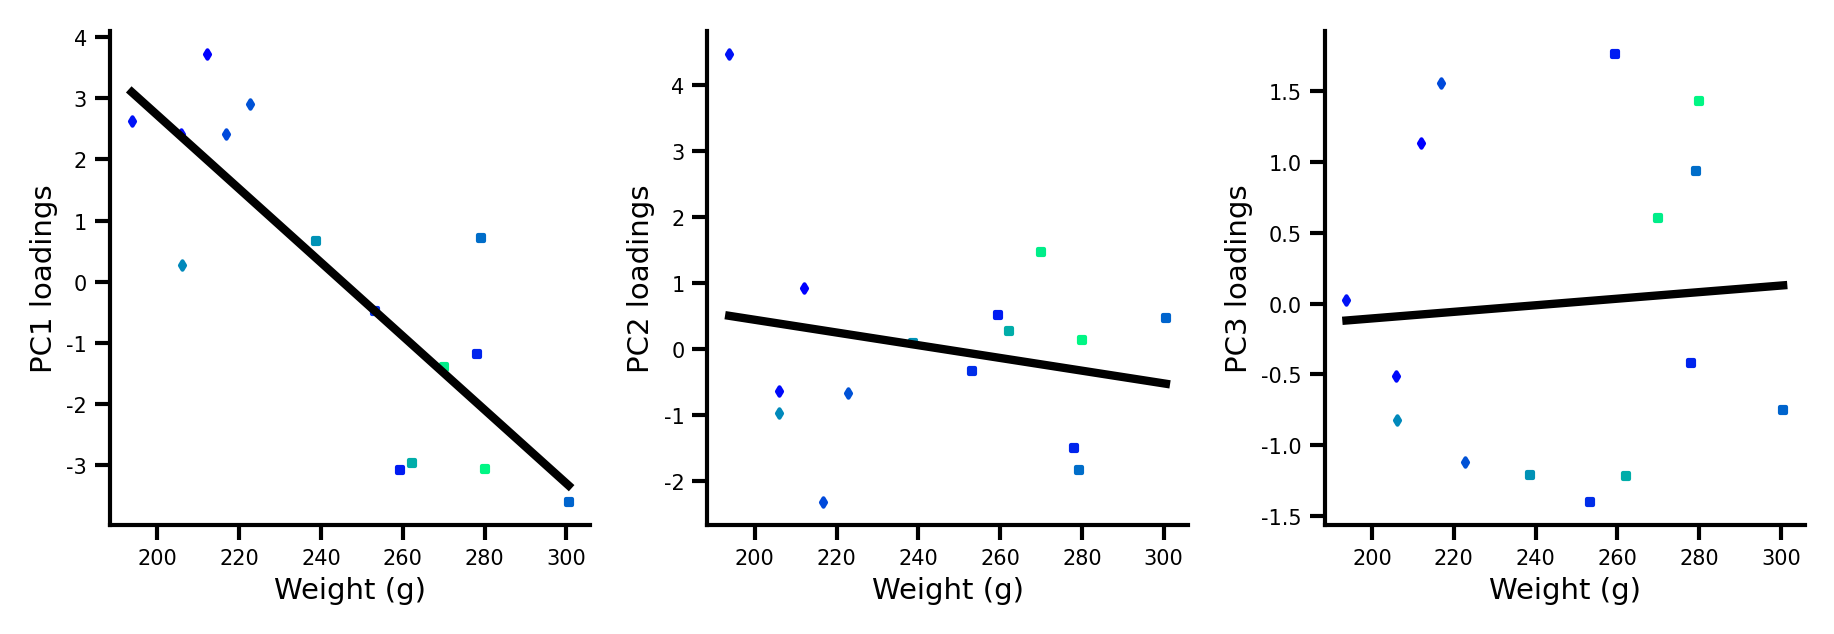

In [471]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23, 
            # 'RatF50': 199.24, 'RatF51': 199.24, 'RatF52': 199.24,
            # 'RatM50': 238.19, 'RatM51': 238.19, 'RatM52': 238.19, 
            'RatM53': 270, 'RatM54': 280 ##########################################
            }

fig, axs = plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True)
for i in range(3):
    x, y = [], []
    for animal, loadings in zip(labels, X_new):
        axs[i].scatter(weights[animal], loadings[i], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=2)
        axs[i].set_xlabel("Weight (g)")
        axs[i].set_ylabel(f"PC{i+1} loadings")

        x.append(weights[animal])
        y.append(loadings[i])


    pearson = stats.pearsonr(x, y)
    print(f'PC{i+1} corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    axs[i].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='black', lw=2)
    # linear regression
    

   

In [494]:
total_effort_by_animal

{'60': {'RatF00': [9.557800246659506,
   18.227374231205996,
   17.322799586522645,
   12.406363867310812,
   14.288644062633374],
  'RatF01': [7.810543561600666,
   14.989777584736077,
   11.274728132732262,
   15.802782396996339,
   10.684465882749878],
  'RatF02': [10.284723650822631,
   8.446107051408974,
   10.083110470940069,
   6.910176355650109,
   13.978071179025289,
   16.450087146181705],
  'RatM00': [9.281148797050578,
   8.95527462093214,
   16.31547189430274,
   12.259771664022143,
   15.431398462659006,
   18.17791518035829],
  'RatM01': [12.16899803820334,
   16.56495008170704,
   19.236306891305084,
   15.555774428420953,
   18.71232853343388,
   20.41613095065241],
  'RatM02': [9.60559099109693,
   12.071192663869455,
   14.399770380085338,
   19.04341473514083,
   16.480903752955008,
   18.309413550833757],
  'RatF30': [11.726409223688568,
   20.31779991822626,
   10.428327075279338,
   13.580770609049283,
   9.660123702493895,
   6.945822671039196],
  'RatF31': [8.6

In [507]:
conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
totEffort = {animal: [] for animal in animalList}
totWater = {animal: [] for animal in animalList}
# for animal in animalList:
#     try:

#         l1 = [total_effort_by_animal[cond][animal] for cond in conds]
#         l2 = [total_drops_by_animal[cond][animal] for cond in conds]

#         print(animal, l1, np.sum(l1), l2, np.sum(l2))
#         totEffort[animal] = np.sum(np.array([total_effort_by_animal[cond][animal] for cond in conds]))
#         totWater[animal] = np.sum([total_drops_by_animal[cond][animal] for cond in conds])
#     except:
#         pass

# fig, axs = plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True)
for idx, animal in enumerate(animalList):
    try:
        totEffort[animal] = np.sum([np.median(total_dist_by_animal[cond][animal]) for cond in conds])
        totWater[animal] = np.sum([np.median(total_drops_by_animal[cond][animal]) for cond in conds])
        # axs[0].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_dist_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
        # axs[1].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_drops_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
        # axs[2].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_effort_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
    except:
        pass

PC1 corr: -0.74, p: 0.0039
PC1 corr: -0.77, p: 0.0022
PC2 corr: -0.15, p: 0.6349
PC2 corr: -0.14, p: 0.6425
PC3 corr: -0.38, p: 0.2012
PC3 corr: -0.45, p: 0.1236


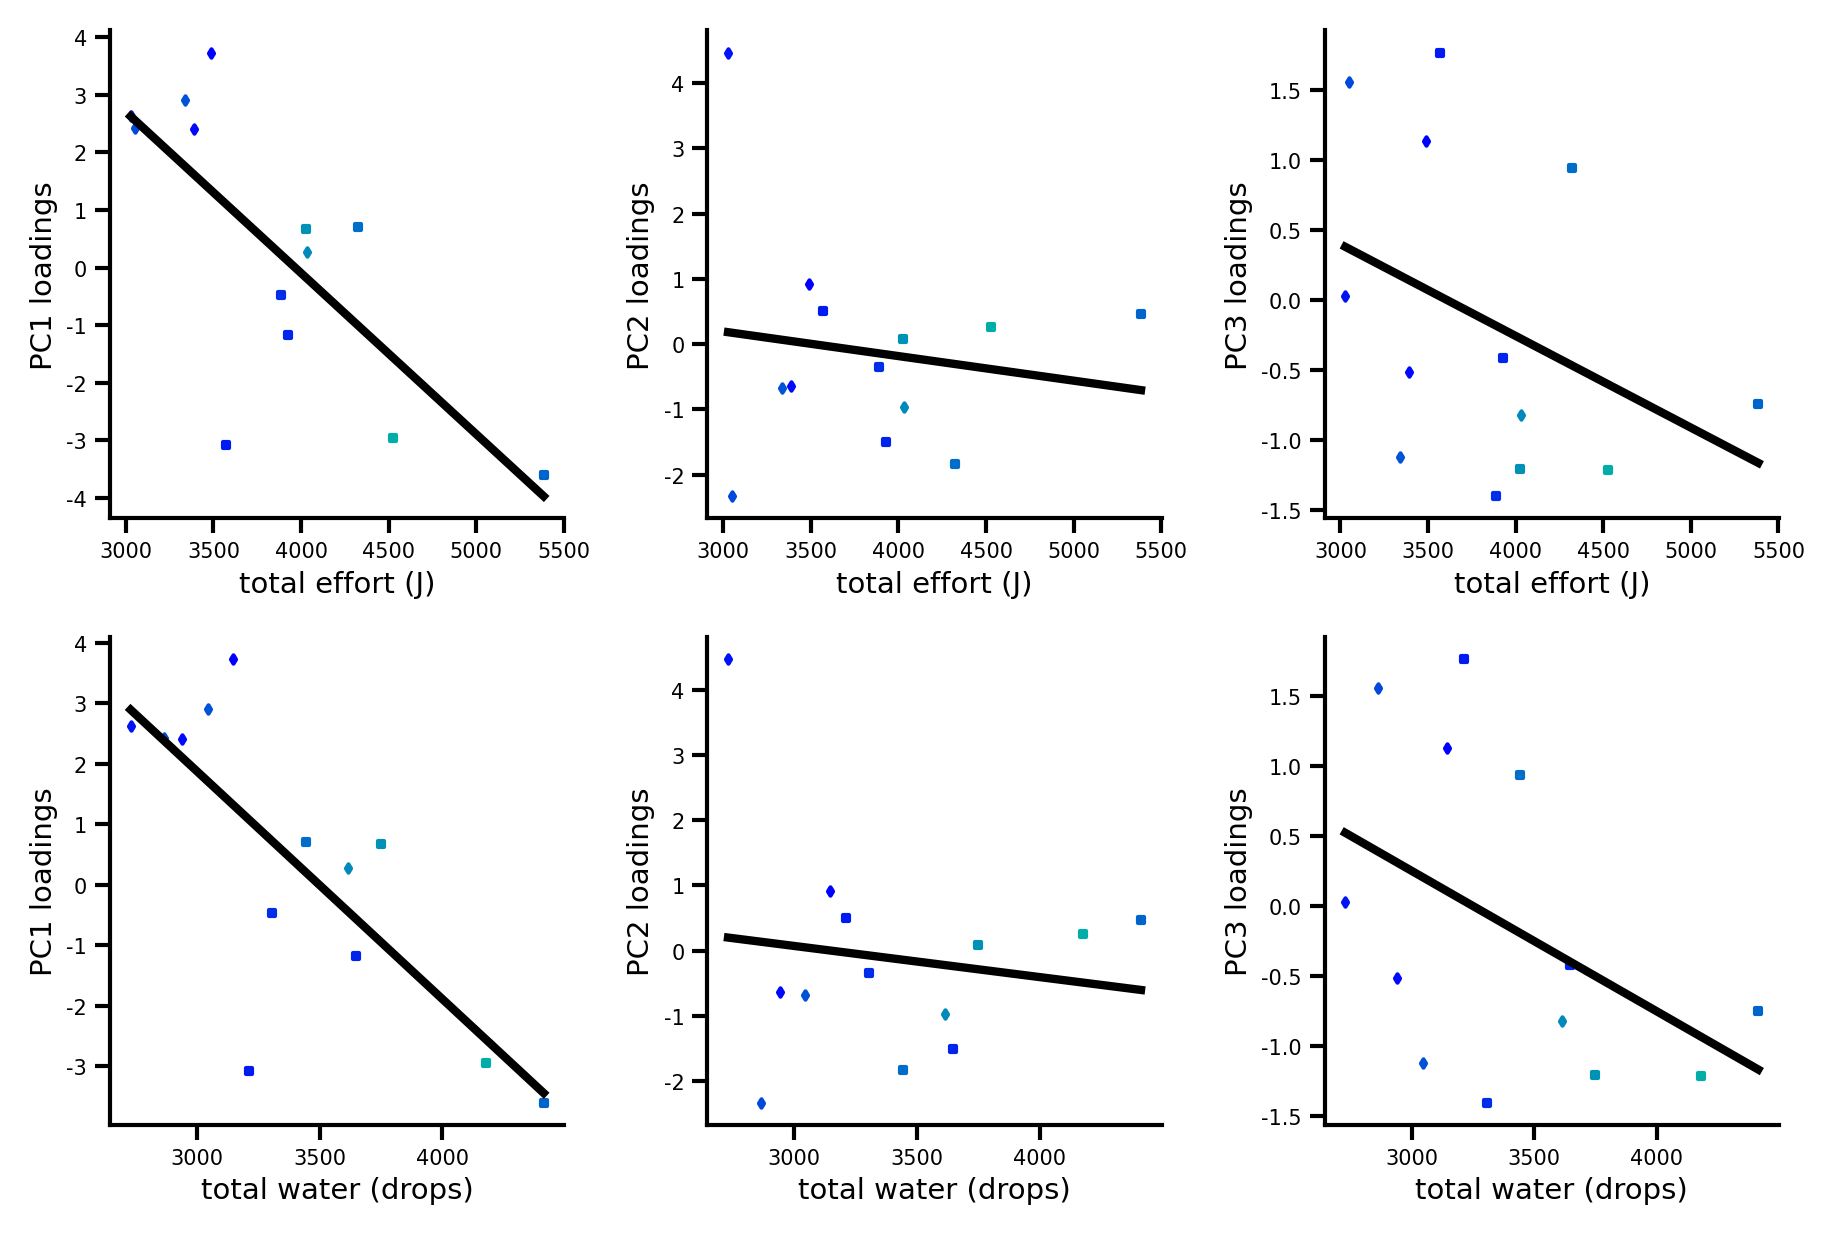

In [510]:
total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))


fig, axs = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True)
for i in range(3):
    xE, yE = [], []
    xW, yW = [], []
    for animal, loadings in zip(labels, X_new):
        try:
            axs[0, i].scatter(totEffort[animal], loadings[i], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=2)
            axs[0, i].set_xlabel("total effort (J)")
            axs[0, i].set_ylabel(f"PC{i+1} loadings")

            xE.append(totEffort[animal])
            yE.append(loadings[i])


            axs[1, i].scatter(totWater[animal], loadings[i], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=2)
            axs[1, i].set_xlabel("total water (drops)")
            axs[1, i].set_ylabel(f"PC{i+1} loadings")

            xW.append(totWater[animal])
            yW.append(loadings[i])

        except:
            pass


    pearson = stats.pearsonr(xE, yE)
    print(f'PC{i+1} corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(xE, yE)
    axs[0, i].plot(np.linspace(np.min(xE), np.max(xE), 100), gradient * np.linspace(np.min(xE), np.max(xE), 100) + intercept, color='black', lw=2)


    pearson = stats.pearsonr(xW, yW)
    print(f'PC{i+1} corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')

    gradient, intercept, r_value, p_value, std_err = stats.linregress(xW, yW)
    axs[1, i].plot(np.linspace(np.min(xW), np.max(xW), 100), gradient * np.linspace(np.min(xW), np.max(xW), 100) + intercept, color='black', lw=2)

In [439]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax=None, n_std=2.0, color='k'):
    '''This is from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 2))

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    # contour
    ellipse_contour = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                        linewidth=1, edgecolor=color, color=color, fill=False, alpha=.8, zorder=1)
    # fill
    ellipse_fill = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                        linewidth=1, edgecolor=color, color=color, fill=True, alpha=0.1, zorder=0)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
                        .rotate_deg(45) \
                        .scale(scale_x, scale_y) \
                        .translate(mean_x, mean_y)

    ellipse_contour.set_transform(transf + ax.transData)
    ellipse_fill.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse_contour), ax.add_patch(ellipse_fill)
    # return ax.add_patch(ellipse)

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  app.launch_new_instance()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


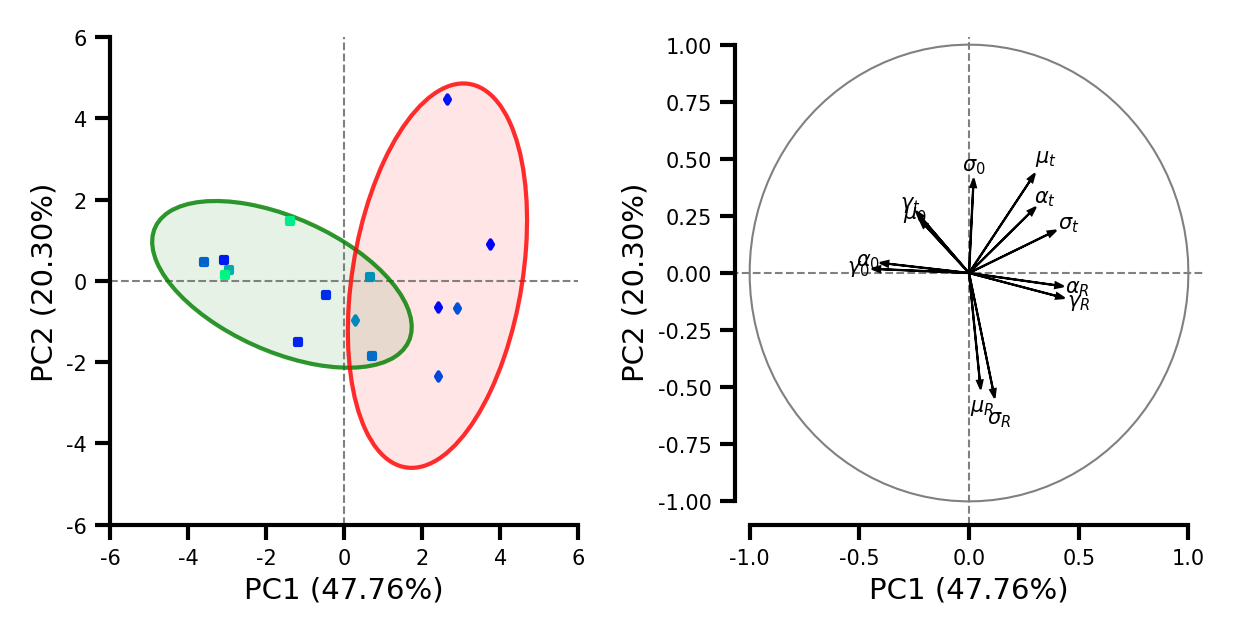

In [511]:
def PCA_individuals_plot(score, labels, pca=pca, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x = score[:,0]  # PC1
    y = score[:,1]  # PC2

    x_males, y_males = [], []
    x_females, y_females = [], []

    for animal in labels:
        ax.scatter(x[labels==animal], y[labels==animal], 
                    c=[rat_markers[animal][0] for _ in range(len(x[labels==animal]))], 
                    marker=rat_markers[animal][1], s=2, zorder=10)

        if 'M' in animal:
            x_males.append(x[labels==animal])
            y_males.append(y[labels==animal])
        else:
            x_females.append(x[labels==animal])
            y_females.append(y[labels==animal])


    ax.axhline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)
    ax.axvline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')


    confidence_ellipse(np.array(x_males).flatten(), np.array(y_males).flatten(), color='g', ax=ax)
    confidence_ellipse(np.array(x_females).flatten(), np.array(y_females).flatten(), color='r', ax=ax)    

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

def PCA_variables_plot(coeff, variables=variables, pca=pca, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    assert len(coeff) == len(variables)

    for i, var in enumerate(variables):
        ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], 
                color='k', linestyle='-', linewidth=.5, width=0.001, head_width=0.025, zorder=1)

        offset = 1.25
        x_offset, y_offset = 0, 0

        # # if two variables are close to each other, we don't want their names to overlap
        # for j in range(i+1, len(variables)):

        #         if np.abs(coeff[i, 0] - coeff[j, 0]) < 0.1 and np.abs(coeff[i, 1] - coeff[j, 1]) < 0.01:
        #             print(i, j , np.abs(coeff[i, 0] - coeff[j, 0]) , np.abs(coeff[i, 1] - coeff[j, 1]))
        #             if np.abs(coeff[i, 0] - coeff[j, 0]) < np.abs(coeff[i, 1] - coeff[j, 1]):
        #                 x_offset = .1
        #             else:
        #                 y_offset = .1

        # heck it, just do it manually
        # if i == 0:
        #     y_offset = .05
        # elif i == 3:
        #     y_offset = -.05
        # elif i == 6:
        #     x_offset = .025
        #     y_offset = .025
        # elif i == 8:
        #     x_offset = -.05
        # elif i == 11:
        #     x_offset = .05

        ax.text(coeff[i, 0]*offset+x_offset, coeff[i, 1]*offset+y_offset, var, 
                color='k', ha='center', va='center', fontsize=5)

    # plot circle
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    ax.plot(x, y, color='gray', linewidth=.5, zorder=0)

    ax.axhline(0, xmin=-1, xmax=1, color='gray', linestyle='--', linewidth=.5, zorder=0)
    ax.axvline(0, ymin=-1, ymax=1, color='gray', linestyle='--', linewidth=.5, zorder=0)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1-1/30, 1+1/30)
    space_axes(ax)
    ax.spines['left'].set_bounds(-1, 1)

v = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
        r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]

# v = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
#         r'$\mu_0$', r"$\mu_t$", r'$\sigma_0$']

fig, axs = plt.subplots(1, 2, figsize=(4, 2), constrained_layout=True)
PCA_individuals_plot(X_new, labels, pca=pca, ax=axs[0])
PCA_variables_plot(np.transpose(pca.components_[0:2, :]), variables=v, pca=pca, ax=axs[1])


# clustering rats and parameters

In [384]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [385]:
# params loadings

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df.columns)
print(loadings)

              PC1       PC2
alpha    0.411945  0.151017
alpha_t -0.359958  0.244132
gamma    0.483718  0.001357
gamma_t  0.265571  0.339991
gamma_R -0.475073 -0.099444
mu       0.218593  0.360971
mu_t    -0.348101  0.474739
sigma   -0.039619  0.660630


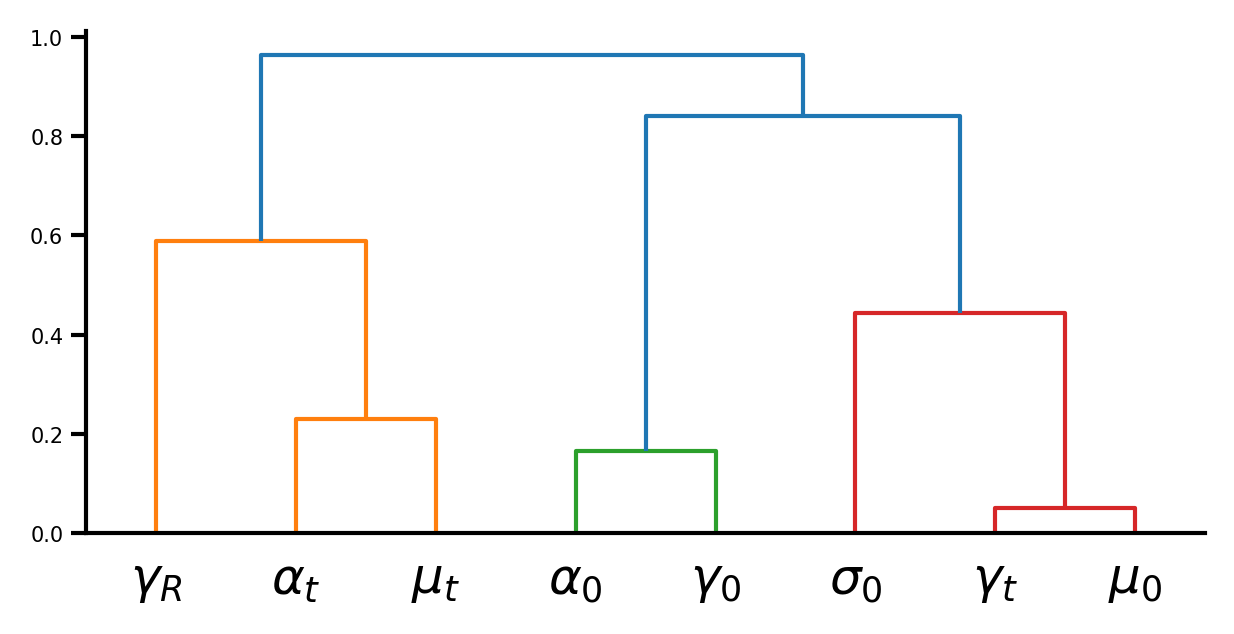

In [390]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
cl_mergings = linkage(loadings, method="complete", metric='euclidean')
dendrogram(cl_mergings, labels=v);

In [391]:
# rats 
df_ = pd.DataFrame(X_new, index=intact, columns=['PC1', 'PC2'])
df_.head()

,PC1,PC2
RatF00,-2.918909,1.385706
RatF01,-1.961630,-0.747065
RatF02,-2.538673,2.968840
RatM00,2.026095,1.647462
RatM01,1.135353,-1.147780


[0 1 0 2 1 1 1 1 2 1 1 1 2 2 2]


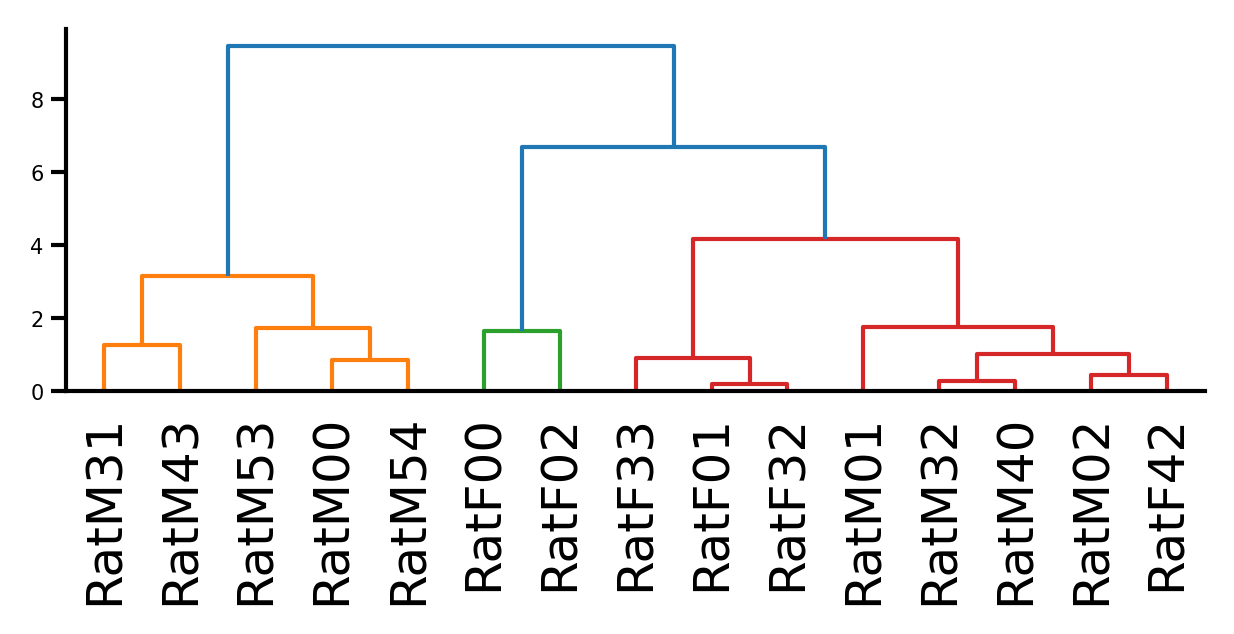

In [393]:
fig = plt.figure(figsize=(4, 2))
cl_mergings = linkage(df_, method="complete", metric='euclidean')
cl_mergings = linkage(df_, method='ward', metric='euclidean')
dendrogram(cl_mergings, labels=intact, #orientation='left');
                orientation='top', leaf_rotation=90)

cl_cluster_labels = cut_tree(cl_mergings, n_clusters=3).reshape(-1, )
print(cl_cluster_labels)


plt.show()

# test all rats

In [512]:
rat_markers = {}

brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')


markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']


for index, animal in enumerate(animalList):
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")


In [513]:
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = 'alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R'

# vars = alpha, alpha_t, gamma, gamma_t, gamma_R, mu, mu_t, sigma,
# names = 'alpha', 'alpha_t', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'sigma'

df = pd.DataFrame(index=animalList)
for var, name in zip(vars, names):
    l = np.array(list(compute_intercept(var, animalList).values()))
    df[name] = l / np.std(l)  # normalize by std to have a mean of 0 and std of 1
    print(name, np.mean(l), np.std(l), np.std(l / np.std(l)))

print(df.head())

# df to array
data = df.to_numpy()
labels = df.index.to_numpy()
variables = df.columns.to_numpy()


alpha 8.921435019309294e-18 0.3252328550983942 1.0
alpha_t -2.6020852139652106e-18 0.06211241470620747 1.0
alpha_R 7.434529182757744e-19 0.09035807405757246 0.9999999999999999
gamma -2.3790493384824782e-17 0.17410176943136402 0.9999999999999999
gamma_t 2.4781763942525814e-19 0.021261459326329564 1.0
gamma_R -1.9825411154020653e-17 0.06320405405342805 0.9999999999999999
mu 9.615324409700017e-17 0.13847674240698266 1.0
mu_t 2.4781763942525814e-19 0.02467222307625765 1.0
mu_R -6.195440985631454e-19 0.031297952744077276 1.0
sigma -5.997961304214451e-18 0.02388566723909708 0.9999999999999999
sigma_t -3.097720492815727e-19 0.007483453005115009 0.9999999999999999
sigma_R -2.7879484435341545e-19 0.009413495760736247 0.9999999999999999
           alpha   alpha_t   alpha_R     gamma   gamma_t   gamma_R        mu  \
RatF00 -2.116956  0.741510  1.569786 -1.866817  0.134251  1.352183 -0.754688   
RatF01 -1.019683  1.622434  0.896451 -1.216751 -0.263678  1.187007 -0.897686   
RatF02 -0.580888  2.580

In [516]:
pca = PCA(n_components=3) # estimate only 2 PCs
X_new = pca.fit_transform(data) # project the original data into the PCA space



0.2363
0.0459
0.7573


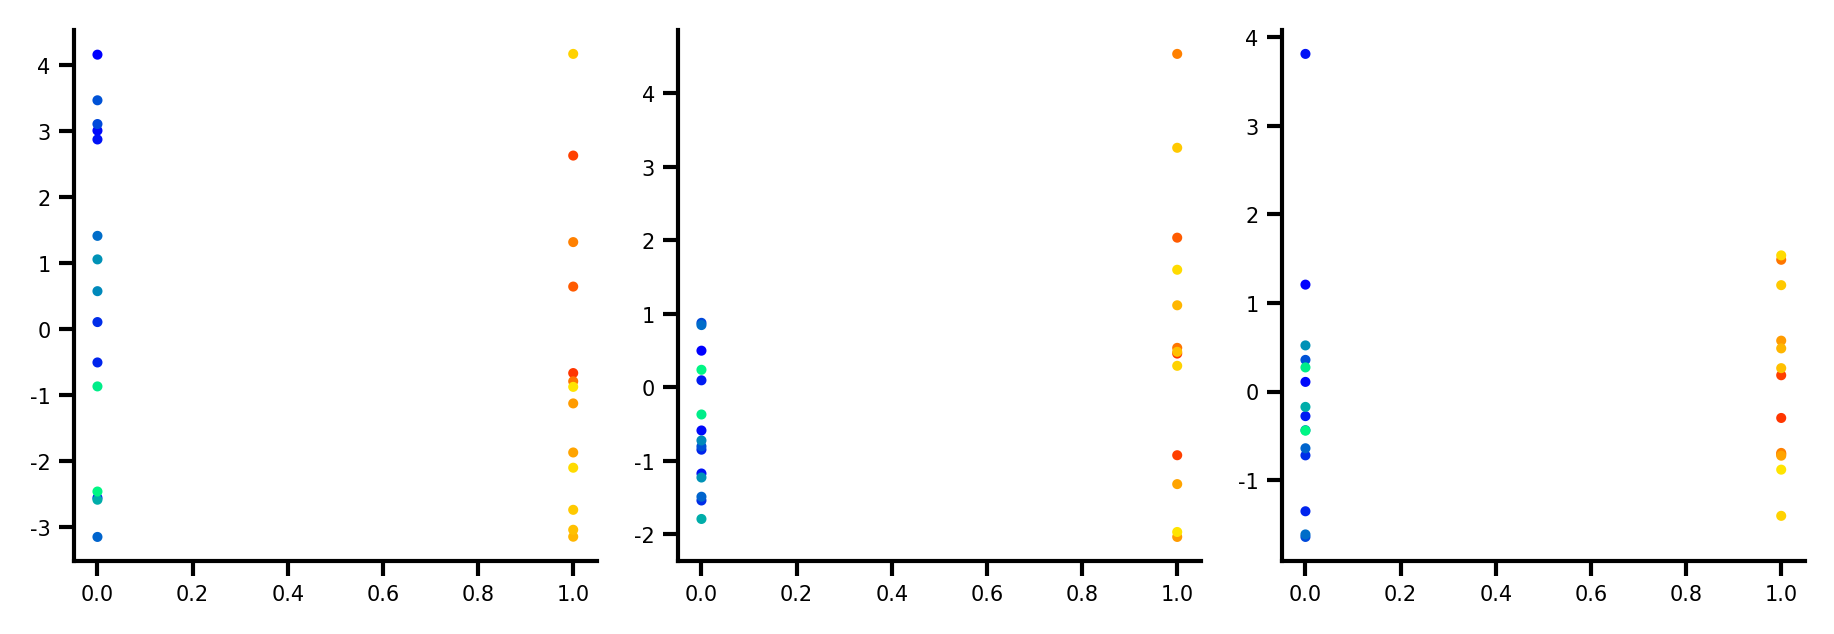

In [518]:
PC1_intact, PC2_intact, PC3_intact = [], [], []
PC1_lesion, PC2_lesion, PC3_lesion = [], [], []

for animal, loadings in zip(labels, X_new):
    if brainstatus[animal] == 'normal':
        PC1_intact.append(loadings[0])
        PC2_intact.append(loadings[1])
        PC3_intact.append(loadings[2])
    else:
        PC1_lesion.append(loadings[0])
        PC2_lesion.append(loadings[1])
        PC3_lesion.append(loadings[2])

fig, axs = plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True)
axs[0].scatter([0]*len(PC1_intact), PC1_intact, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] == 'normal'], s=2)
axs[0].scatter([1]*len(PC1_lesion), PC1_lesion, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] != 'normal'], s=2)

axs[1].scatter([0]*len(PC2_intact), PC2_intact, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] == 'normal'],  s=2)
axs[1].scatter([1]*len(PC2_lesion), PC2_lesion, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] != 'normal'],  s=2)

axs[2].scatter([0]*len(PC3_intact), PC3_intact, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] == 'normal'], s=2)
axs[2].scatter([1]*len(PC3_lesion), PC3_lesion, c=[rat_markers[animal][0] for animal in labels if brainstatus[animal] != 'normal'],  s=2)


print(exact_mc_perm_test(PC1_intact, PC1_lesion))
print(exact_mc_perm_test(PC2_intact, PC2_lesion))
print(exact_mc_perm_test(PC3_intact, PC3_lesion))


/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  app.launch_new_instance()
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


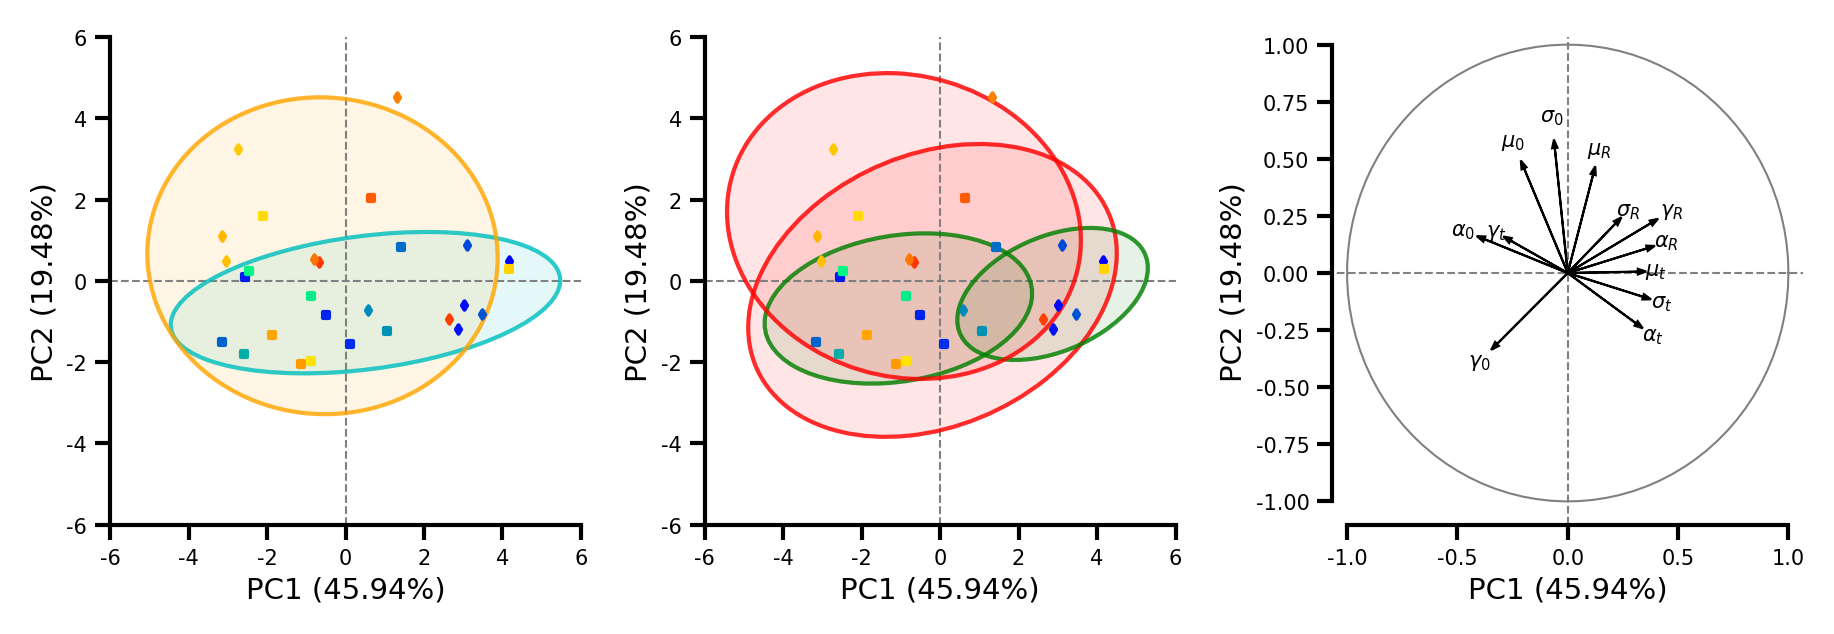

In [573]:
v = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
        r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]

# v = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", 
#         r'$\mu_0$', r"$\mu_t$", r'$\sigma_0$']


def PCA_lesion(score, labels, pca=pca, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x = score[:,0]  # PC1
    y = score[:,1]  # PC2

    x_intact, y_intact = [], []
    x_lesion, y_lesion = [], []

    for animal in labels:
        ax.scatter(x[labels==animal], y[labels==animal], 
                    c=[rat_markers[animal][0] for _ in range(len(x[labels==animal]))], 
                    marker=rat_markers[animal][1], s=2, zorder=10)

        if animal in intact:
            x_intact.append(x[labels==animal])
            y_intact.append(y[labels==animal])
        else:
            x_lesion.append(x[labels==animal])
            y_lesion.append(y[labels==animal])


    ax.axhline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)
    ax.axvline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')


    confidence_ellipse(np.array(x_intact).flatten(), np.array(y_intact).flatten(), color='c', ax=ax)
    confidence_ellipse(np.array(x_lesion).flatten(), np.array(y_lesion).flatten(), color='orange', ax=ax)    

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

def PCA_individualsXlesion(score, labels, pca=pca, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x = score[:,0]  # PC1
    y = score[:,1]  # PC2

    x_intactM, y_intactM = [], []
    x_lesionM, y_lesionM = [], []
    x_intactF, y_intactF = [], []
    x_lesionF, y_lesionF = [], []

    for animal in labels:
        ax.scatter(x[labels==animal], y[labels==animal], 
                    c=[rat_markers[animal][0] for _ in range(len(x[labels==animal]))], 
                    marker=rat_markers[animal][1], s=2, zorder=10)

        if animal in intact:
            if 'M' in animal:
                x_intactM.append(x[labels==animal])
                y_intactM.append(y[labels==animal])
            else:
                x_intactF.append(x[labels==animal])
                y_intactF.append(y[labels==animal])

        else:
            if 'M' in animal:
                x_lesionM.append(x[labels==animal])
                y_lesionM.append(y[labels==animal])
            else:
                x_lesionF.append(x[labels==animal])
                y_lesionF.append(y[labels==animal])


    ax.axhline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)
    ax.axvline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')

    confidence_ellipse(np.array(x_intactM).flatten(), np.array(y_intactM).flatten(), color='g', ax=ax)
    confidence_ellipse(np.array(x_lesionM).flatten(), np.array(y_lesionM).flatten(), color='r', ax=ax)
    confidence_ellipse(np.array(x_intactF).flatten(), np.array(y_intactF).flatten(), color='g', ax=ax)
    confidence_ellipse(np.array(x_lesionF).flatten(), np.array(y_lesionF).flatten(), color='r', ax=ax)

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)


fig, axs = plt.subplots(1,3 , figsize=(6, 2), constrained_layout=True)
PCA_lesion(X_new, labels, pca=pca, ax=axs[0])
PCA_individualsXlesion(X_new, labels, pca=pca, ax=axs[1])
PCA_variables_plot(np.transpose(pca.components_[0:2, :]), variables=v, pca=pca, ax=axs[2])

              PC1       PC2
alpha   -0.377698  0.148270
alpha_t  0.309566 -0.220458
alpha_R  0.358953  0.107953
gamma   -0.320185 -0.310437
gamma_t -0.259272  0.142025
gamma_R  0.377228  0.218697
mu      -0.197925  0.458160
mu_t     0.317763  0.005926
mu_R     0.115015  0.431082
sigma   -0.058558  0.547191
sigma_t  0.341528 -0.104166
sigma_R  0.217203  0.217587


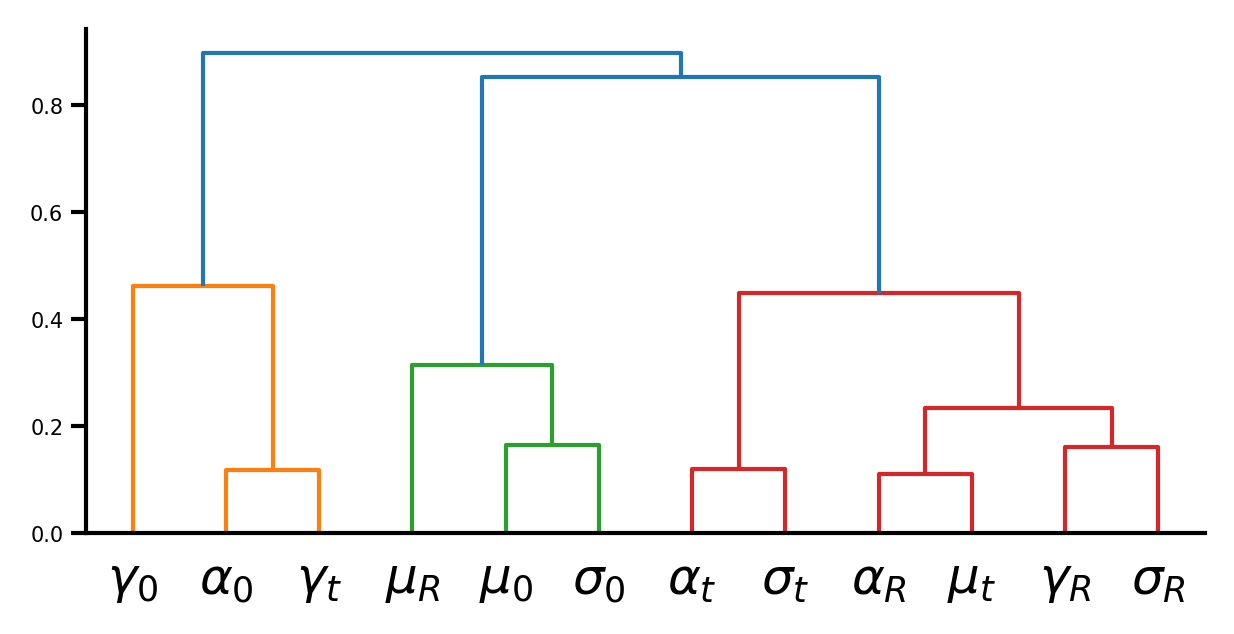

In [372]:
# params loadings

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df.columns)
print(loadings)
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
cl_mergings = linkage(loadings, method="complete", metric='euclidean')
dendrogram(cl_mergings, labels=v);

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 2 0 0 1 1 1 1 1 1 0 1 1 0 1]


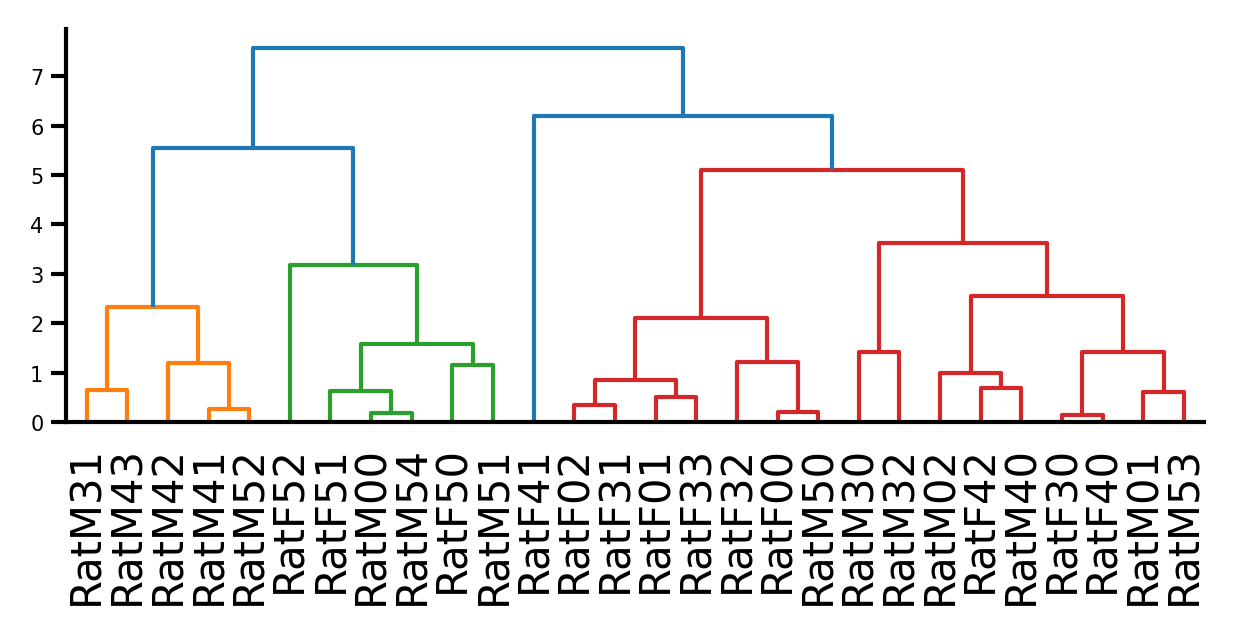

In [373]:
# rats 
df_ = pd.DataFrame(X_new, index=animalList, columns=['PC1', 'PC2'])
df_.head()
fig = plt.figure(figsize=(4, 2))
cl_mergings = linkage(df_, method="complete", metric='euclidean')
# cl_mergings = linkage(df_, method='ward', metric='euclidean')
dendrogram(cl_mergings, labels=animalList, #orientation='left');
                orientation='top', leaf_rotation=90)

cl_cluster_labels = cut_tree(cl_mergings, n_clusters=3).reshape(-1, )
print(cl_cluster_labels)


plt.show()

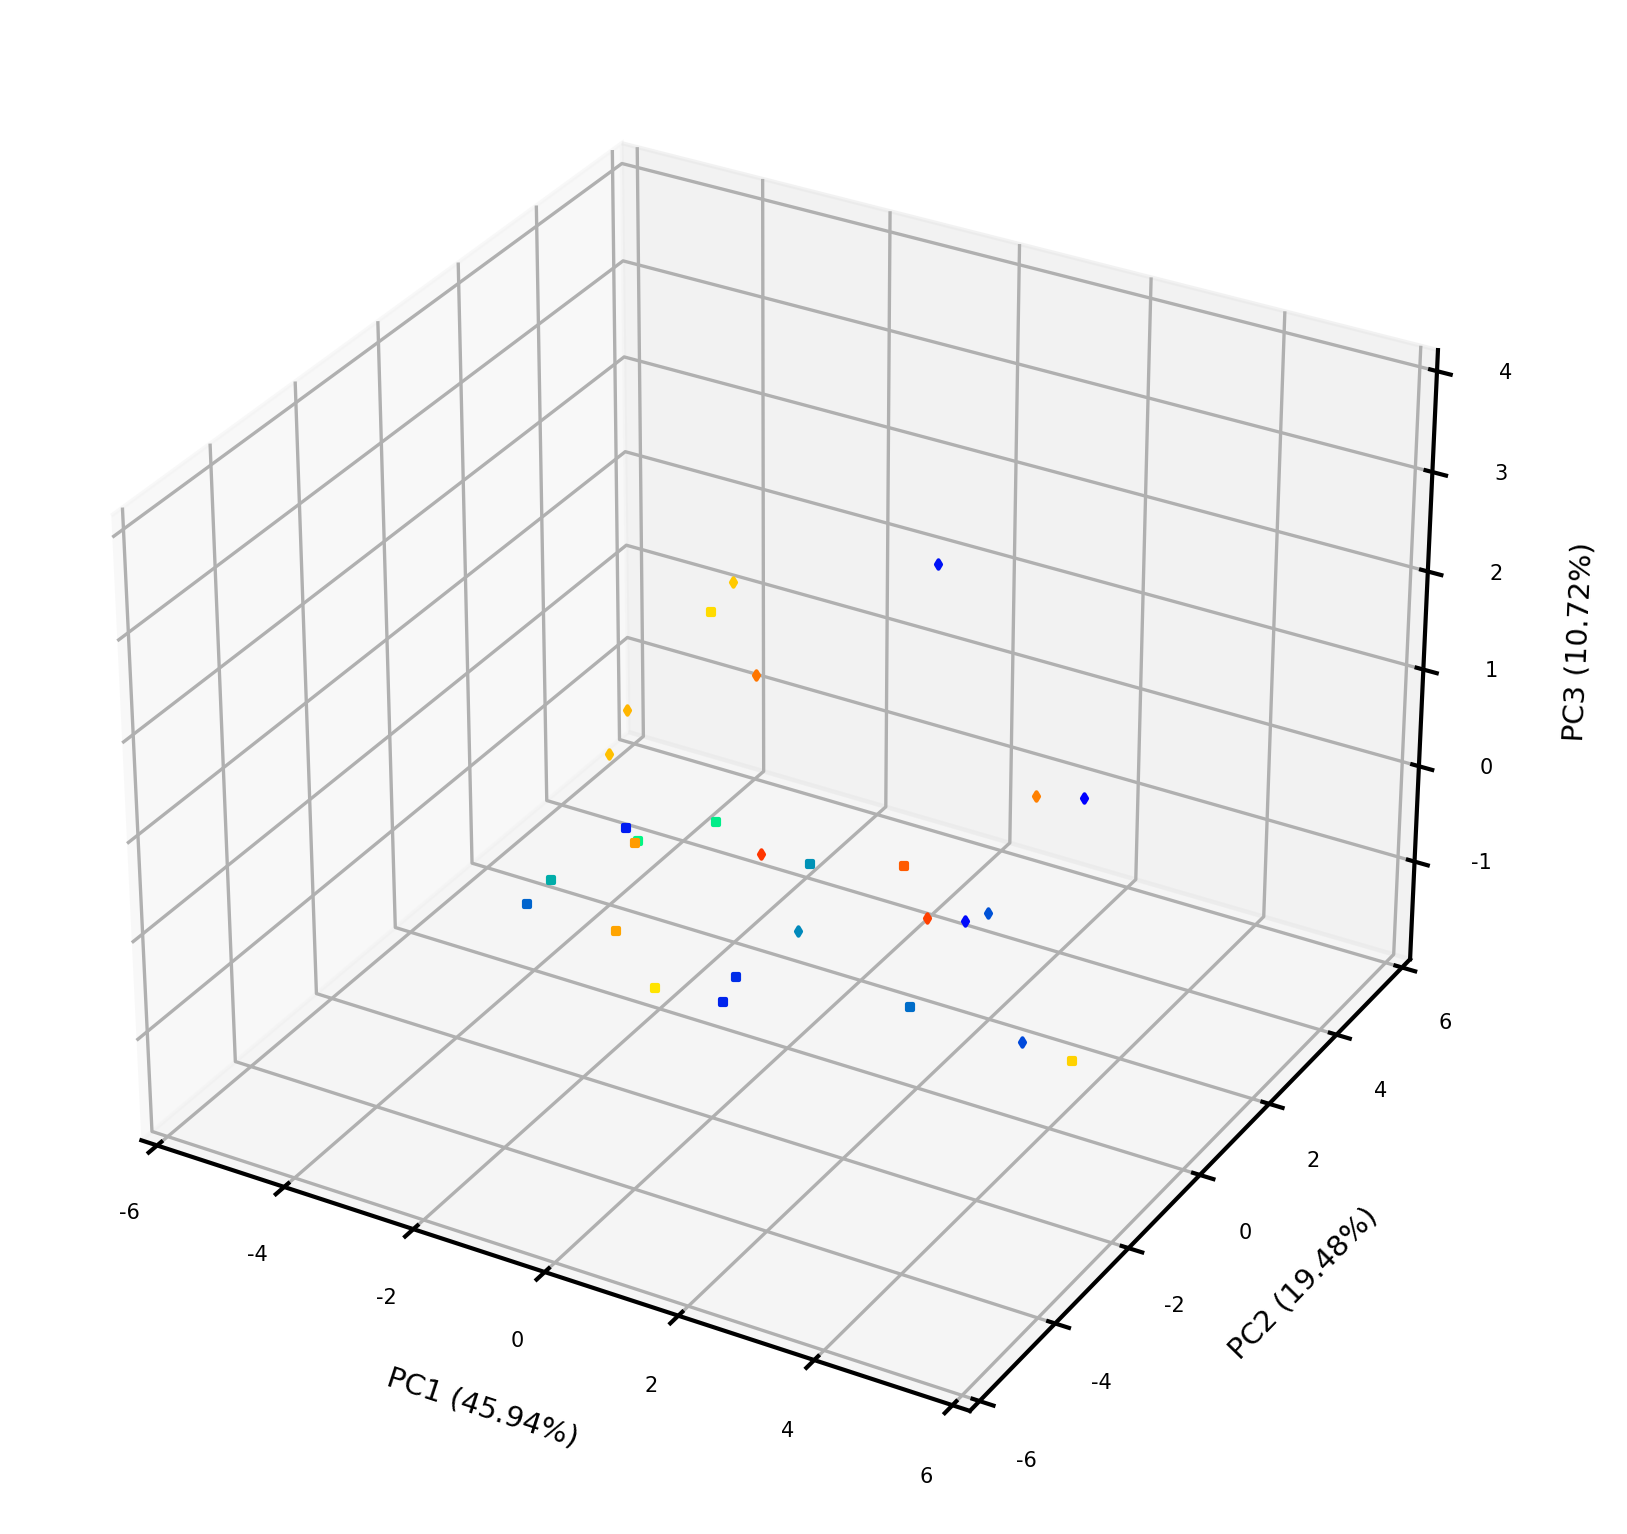

In [419]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


def PCA_3d_plot(score, labels, pca=pca, ax=None):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')

    x = score[:,0]  # PC1
    y = score[:,1]  # PC2
    z = score[:,2]  # PC3

    x_males, y_males, z_males = [], [], []
    x_females, y_females, z_females = [], [], []


    for animal in labels:
        ax.scatter(x[labels==animal], y[labels==animal], z[labels==animal],
                    c=[rat_markers[animal][0] for _ in range(len(x[labels==animal]))], 
                    marker=rat_markers[animal][1], s=2, zorder=10)

        # if 'M' in animal:
        #     x_males.append(x[labels==animal])
        #     y_males.append(y[labels==animal])
        # else:
        #     x_females.append(x[labels==animal])
        #     y_females.append(y[labels==animal])


    # ax.axhline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)
    # ax.axvline(0, color='gray', linestyle='--', linewidth=.5, zorder=0)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')


    # confidence_ellipse(np.array(x_males).flatten(), np.array(y_males).flatten(), color='g', ax=ax)
    # confidence_ellipse(np.array(x_females).flatten(), np.array(y_females).flatten(), color='r', ax=ax)    

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

PCA_3d_plot(X_new, labels, pca=pca)

# archetype with intercepts

In [575]:
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
vars = alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R
names = 'alpha', 'alpha_t', 'alpha_R', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'mu_R', 'sigma', 'sigma_t', 'sigma_R'

# vars = alpha, alpha_t, gamma, gamma_t, gamma_R, mu, mu_t, sigma,
# names = 'alpha', 'alpha_t', 'gamma', 'gamma_t', 'gamma_R', 'mu', 'mu_t', 'sigma'

df = pd.DataFrame(index=animalList)
for var, name in zip(vars, names):
    l = np.array(list(compute_intercept(var, animalList).values()))
    df[name] = l / np.std(l)  # normalize by std to have a mean of 0 and std of 1
    print(name, np.mean(l), np.std(l), np.std(l / np.std(l)))

print(df.head())

# df to array
data = df.to_numpy()
labels = df.index.to_numpy()
variables = df.columns.to_numpy()

alpha 8.921435019309294e-18 0.3252328550983942 1.0
alpha_t -2.6020852139652106e-18 0.06211241470620747 1.0
alpha_R 7.434529182757744e-19 0.09035807405757246 0.9999999999999999
gamma -2.3790493384824782e-17 0.17410176943136402 0.9999999999999999
gamma_t 2.4781763942525814e-19 0.021261459326329564 1.0
gamma_R -1.9825411154020653e-17 0.06320405405342805 0.9999999999999999
mu 9.615324409700017e-17 0.13847674240698266 1.0
mu_t 2.4781763942525814e-19 0.02467222307625765 1.0
mu_R -6.195440985631454e-19 0.031297952744077276 1.0
sigma -5.997961304214451e-18 0.02388566723909708 0.9999999999999999
sigma_t -3.097720492815727e-19 0.007483453005115009 0.9999999999999999
sigma_R -2.7879484435341545e-19 0.009413495760736247 0.9999999999999999
           alpha   alpha_t   alpha_R     gamma   gamma_t   gamma_R        mu  \
RatF00 -2.116956  0.741510  1.569786 -1.866817  0.134251  1.352183 -0.754688   
RatF01 -1.019683  1.622434  0.896451 -1.216751 -0.263678  1.187007 -0.897686   
RatF02 -0.580888  2.580

In [583]:
def proc(data):
    model = AA_Fast(n_archetypes=3, max_iter=1000, tol=1e-6, verbose=True)
    archs = model.fit(data)
    return archs

def transform(data):
    A = proc(data).transform(data)
    return A

s = transform(data)
s.shape

(28, 3)

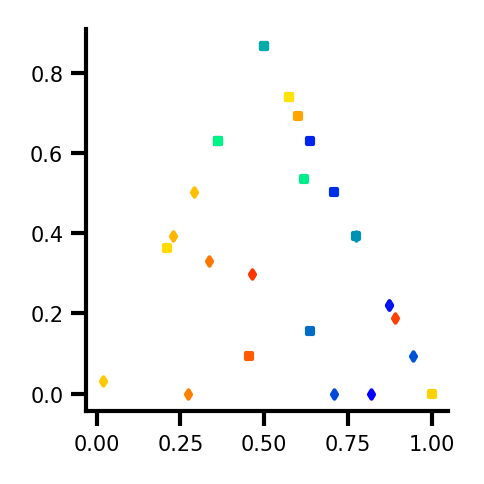

In [584]:
def scatter_triangle(points, labels=None, ax=None, vmin=0, vmax=1):

    if ax is None:
        fig, ax = plt.subplots(figsize=(1.5, 1.5))

    def _project(p):
        a = p[0]
        b = p[1]
        x = a + b/2
        y = np.sqrt(3) / 2  * b
        return np.array([x, y])

    x, y = list(zip(*[_project(p) for p in points]))

    for i in range(len(x)):
        if labels is None:
            ax.scatter(x[i], y[i], s=2, color='black')
        else:
            ax.scatter(x[i], y[i], s=2, color=rat_markers[labels[i]][0], marker=rat_markers[labels[i]][1])

scatter_triangle(s, labels)

# bootstrap confidence interval

In [98]:
conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
def compute_ICC(var, animalList=animalList):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    expected_60 = np.mean([var[animal]["60"] for animal in animalList])
    expected_90 = np.mean([var[animal]["90"] for animal in animalList])
    expected_120 = np.mean([var[animal]["120"] for animal in animalList])
    expected_20 = np.mean([var[animal]["20"] for animal in animalList])
    expected_10 = np.mean([var[animal]["10"] for animal in animalList])
    expected_2 = np.mean([var[animal]["2"] for animal in animalList])
    expected_rev10 = np.mean([var[animal]["rev10"] for animal in animalList])
    expected_rev20 = np.mean([var[animal]["rev20"] for animal in animalList])

    individual_intercepts = {}
    remaining_residuals = {}
    x = np.arange(len(conds))
    ymax = 0

    for animal in animalList:
        y = np.array([
            var[animal]["60"], 
                        var[animal]["90"], 
                        var[animal]["120"],
                        var[animal]["rev20"], 
                        var[animal]["rev10"], 
                        var[animal]["2"], 
                        var[animal]["10"], 
                        var[animal]["20"]])

        y_expected = np.array([
                                var[animal]["60"] - expected_60,
                                var[animal]["90"] - expected_90,
                                var[animal]["120"] - expected_120,
                                var[animal]["rev20"] - expected_rev20,
                                var[animal]["rev10"] - expected_rev10,
                                var[animal]["2"] - expected_2,
                                var[animal]["10"] - expected_10,
                                var[animal]["20"] - expected_20])


        #find intercept
        X = np.ones((len(x), 1))
        Y = y_expected.reshape(-1, 1)
        coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]
        intercept = coefficients[0][0]
        individual_intercepts[animal] = intercept
        # print('func', individual_intercepts[animal])

        ######################################

        y_corrected = np.array([
                                var[animal]["60"] - expected_60 - individual_intercepts[animal],
                                var[animal]["90"] - expected_90 - individual_intercepts[animal],
                                var[animal]["120"] - expected_120 - individual_intercepts[animal],
                                var[animal]["rev20"] - expected_rev20 - individual_intercepts[animal],
                                var[animal]["rev10"] - expected_rev10 - individual_intercepts[animal],
                                var[animal]["2"] - expected_2 - individual_intercepts[animal],
                                var[animal]["10"] - expected_10 - individual_intercepts[animal],
                                var[animal]["20"] - expected_20 - individual_intercepts[animal]])
        
        
        remaining_residuals[animal] = np.var(y_corrected)

    # print(np.var(list(individual_intercepts.values())))

    alp = np.var(list(individual_intercepts.values()))
    eps = np.mean(list(remaining_residuals.values()))
    # print(alp, eps)
    ICC_pop = alp / (alp + eps)


    # individual ICC
    ICC_indiv = {}
    for animal in animalList:
        ICC_indiv[animal] = alp / (alp + remaining_residuals[animal])

    return ICC_pop, ICC_indiv

compute_ICC(alpha, animalList=animalList)
# # do_stuff(sigma)
# do_stuff(alpha, 'alpha')

(0.6228953479996814,
 {'RatF00': 0.9296281251342547,
  'RatF01': 0.9417597692468322,
  'RatF02': 0.7124565959150614,
  'RatM00': 0.8753128607108941,
  'RatM01': 0.9114759539515394,
  'RatM02': 0.7225846477795401,
  'RatF30': 0.3188575905832495,
  'RatF31': 0.6439569996037576,
  'RatF32': 0.7569305983298166,
  'RatF33': 0.910769607855502,
  'RatM30': 0.5949983911432472,
  'RatM31': 0.6339388576253467,
  'RatM32': 0.7052121325296351,
  'RatF40': 0.6333023736699962,
  'RatF41': 0.4551463946340863,
  'RatF42': 0.7088443550052457,
  'RatM40': 0.45666294893042886,
  'RatM41': 0.7446648929890477,
  'RatM42': 0.43605274228704755,
  'RatM43': 0.46591328783008157})

{'RatF00': {'60': 0.48654548013853793, '90': 0.4339382674481269, '120': 0.7906697168021092, '20': 0.7481257705657565, '10': 0.4928906099266325, '2': 1.059944857254574, 'rev10': 1.2171573168035366, 'rev20': 1.0361747978545766}, 'RatF01': {'60': 1.1678023233114363, '90': 0.8722449295687495, '120': 1.4048615824162365, '20': 0.7186349578133748, '10': 0.9575323668503536, '2': 0.5839821140115244, 'rev10': 1.595916043087436, 'rev20': 1.0646910902122346}, 'RatF02': {'60': 1.4439634166265007, '90': 1.1459763644212426, '120': 1.2402358913661649, '20': 2.174069392721923, '10': 1.9672368369629736, '2': 1.4772022194472816, 'rev10': 2.118367200478882, 'rev20': 2.327209364063265}, 'RatM00': {'60': 1.8077288455324791, '90': 2.1516198794748016, '120': 2.178597766134616, '20': 2.348967326764515, '10': 2.6533134541681562, '2': 2.495687589492743, 'rev10': 2.489826063132188, 'rev20': 2.263013564189079}, 'RatM01': {'60': 0.8654927886250476, '90': 0.6150714669830823, '120': 0.6947009561604511, '20': 1.750466

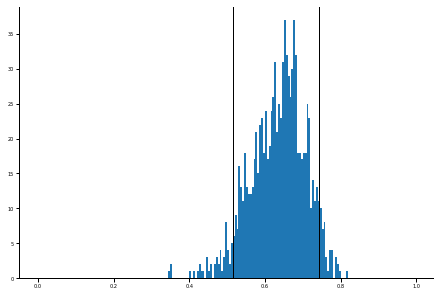

In [101]:
# not working
def generate_bootstrap_samples(var, intercept_variance, residual_variance, n=1000):
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]

    samples = []
    for i in range(n):
        sample = {}
        for animal in animalList:
            rand1 = np.random.normal(0, np.sqrt(intercept_variance))
            sample[animal] = {}
            for cond in conds:
                expected = np.mean([var[animal][cond] for animal in animalList])
                rand2 = np.random.normal(0, np.sqrt(residual_variance))
                sample[animal][cond] = var[animal][cond] + rand1 + rand2
        samples.append(sample)
    return samples

n = 1000
ICCs = np.zeros(n)
samples = generate_bootstrap_samples(alpha,  
                                                    # 0, 0, 
                                                    0.08384340320952754, 0.05075930891342514,
                                                    # 0.09718749881658037, 0.03298486407655271, 
                                                    n=n)
print(samples[0])

for i, sample in enumerate(samples):
    ICC_pop, ICC_indiv = compute_ICC(sample)
    ICCs[i] = ICC_pop

conf_bottom = np.percentile(ICCs, 5)
conf_top = np.percentile(ICCs, 95)

plt.hist(ICCs, bins=np.arange(0, 1, 0.005))
plt.axvline(conf_bottom, color='black')
plt.axvline(conf_top, color='black')
print('IC', conf_bottom, conf_top)
# 0 RatF00 60 1.2839231268010671

0.5609153855952232 0.6233357222682461


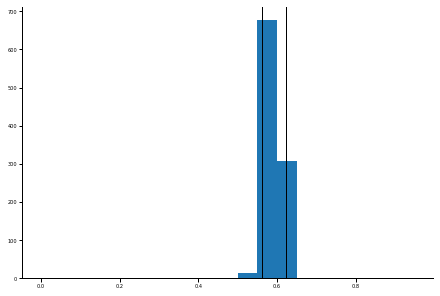

In [76]:
n_samples = 1000


var = alpha
a = 0.083
b = 0.0507

ICCs = np.zeros((n_samples))

for i in range(n_samples):
    test = {}
    for animal in animalList:
        test[animal] = {}
        for cond in conds:
            test[animal][cond] = var[animal][cond] + np.random.normal(0, a) + np.random.normal(0, b) 
    ICCs[i] = compute_ICC(test)[0]

conf_bottom = np.percentile(ICCs, 5)
conf_top = np.percentile(ICCs, 95)

plt.hist(ICCs, bins=np.arange(0, 1, 0.05))
plt.axvline(conf_bottom, color='black')
plt.axvline(conf_top, color='black')
print(conf_bottom, conf_top)


# for subject in range(n_subjects):
#     test[subject] = {}
#     for measurement in range(n_measurements):
#         # test[subject][measurement] = expected_value[measurement] + np.random.normal(0, a) + np.random.normal(0, b)
#         test[subject][measurement] = 0 + np.random.normal(0, a) + np.random.normal(0, b)


# test

In [48]:
g = np.random.normal(0, np.sqrt(a), 100)
np.std(g)

0.3273435864507606

In [40]:
ICCs

array([0.5976352 , 0.60859623, 0.56533921, 0.56063723, 0.56992529,
       0.61344224, 0.57472476, 0.61791762, 0.59429285, 0.60825312])

In [28]:
np.random.seed(42)
n_subjects = 10
n_measurements = 5

subject_ids = np.repeat(range(n_subjects), n_measurements)
expected_value = 0#np.random.randn(n_subjects)
individual_intercepts = np.random.randn(n_subjects)
measurements = expected_value[subject_ids] + individual_intercepts[subject_ids] + np.random.randn(n_subjects * n_measurements) * 0.3

# Calculate residuals after accounting for expected value and individual intercept
residuals = measurements - expected_value[subject_ids] - individual_intercepts[subject_ids]

# Create a DataFrame with correct lengths
data = {'subject_id': subject_ids, 'measurement': measurements, 'expected_value': np.repeat(expected_value, n_measurements), 'individual_intercept': np.repeat(individual_intercepts, n_measurements)}

# Calculate total mean and within-subject mean
total_mean = np.mean(measurements)
within_subject_means = np.array([np.mean(measurements[subject_ids == subject_id]) for subject_id in range(n_subjects)])

# Calculate variance components
between_subjects_variance = np.var(within_subject_means, ddof=1)
within_subjects_variance = np.mean(np.square(residuals - np.mean(residuals)), axis=0)

# Calculate ICC corrected by expected value and individual intercept
corrected_ICC = between_subjects_variance / (between_subjects_variance + within_subjects_variance)
print("Corrected Intraclass Correlation Coefficient (ICC):", corrected_ICC)

TypeError: 'int' object is not subscriptable